In [1]:
import copy
import sys
import random
import pickle
import torch
import warnings
import logging
import gc
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_optimizer as optim_mod
import os
import itertools

from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning
from torch.nn.modules.transformer import TransformerEncoderLayer, TransformerEncoder

from torch.cuda.amp import autocast, GradScaler
from IPython.display import display, HTML

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

from IPython.display import Javascript, display
from sklearn.utils.multiclass import unique_labels

import optuna
import torch.optim as optim

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

general_logger = logging.getLogger('general_logger')
general_handler = logging.FileHandler('NoForceTransformers_log.txt', mode='w')
general_handler.setFormatter(logging.Formatter('%(message)s'))
general_logger.setLevel(logging.INFO)
general_logger.addHandler(general_handler)


def log(message):
    general_logger.info(message) 
    print(message)     


In [2]:
Params={'lr': 0.0007379903593864751, 'dropout': 0.11402389385748135, 'batch_size': 619, 'num_layers': 4, 'd_model': 493,
         'weight_baja1': 13.887450747162747, 'weight_baja2': 70.9946897814277, 
         'weight_continua': 1.8534423980414036, 'weight_decay': 0.0003093598055270367}

In [3]:
Params={'lr': 0.0007379903593864751, 'dropout': 0.11402389385748135, 'batch_size': 608, 'num_layers': 4, 'd_model': 512, 
        'weight_baja1': 10.887450747162747, 'weight_baja2': 80.9946897814277, 
        'weight_continua': 1.534423980414036, 'weight_decay': 0.0003093598055270367, 'dim_feedforward': 949, 
        'beta1': 0.9279914312981336, 'beta2': 0.9729720290390763, 'eps': 3.9267980177920674e-06, 'grad_clip': 0.8245199110894906, 
        'gamma': 3, 'scheduler_patience': 7, 'scheduler_factor': 0.10134679071433805}

In [4]:
Params={'lr': 1e-07, 'dropout': 0.1, 'batch_size': 400, 'num_layers': 8, 'd_model': 420, 
         'weight_baja1': 60, 'weight_baja2': 70, 'weight_continua': 1, 
         'weight_decay': 5e-5, 'dim_feedforward': 1000, 'beta1': 0.93, 'beta2': 0.97, 
         'eps': 2.1e-06, 'grad_clip': 0.69, 'gamma': 4.0, 'reward_baja_2': 117, 
         'penalty_baja_2': -3, 'miss_baja_2_penalty': -100, 'scheduler_patience': 2, 'scheduler_factor': 0.69, 
         'num_heads': 10, 'factor': 50}

In [5]:
batch_size = Params['batch_size']
val_batch_size = 200

#Model Parameters
input_dim = 306
num_classes = 5
num_heads = 4 
d_model = Params['d_model']    
dim_feedforward=Params['dim_feedforward'] 
dropout = Params['dropout']
num_layers = Params['num_layers']   
  

beta1 = Params['beta1']
beta2 = Params['beta2']
eps = Params['eps']

#Train Parameters
num_epochs = 300
learning_rate= Params['lr']
weight_decay = Params['weight_decay']

#Loss parameters
gamma = Params['gamma']
miss_baja_2_penalty = Params['miss_baja_2_penalty']
reward_baja_2 = Params['reward_baja_2']
penalty_baja_2 = Params['penalty_baja_2']


#Split Parameters
split_by_clients = True
client_split_ratios=(0.8, 0.2, 0.0)

train_steps = 29
val_steps = 2
test_steps = 0

REDUCE = False
num_clients = 20000

UNDERSAMPLE = False
majority_class = 5  
padding_label = 69   
undersample_percentage = 0.5


#Choose Model
useTRANSFORMERS = False
useTRANSFORMERSHYBRID = False

useLSTM = False
useLSTMAttention = False
useLSTMWeightAtention = False
useLSTMEncoder = False

#For Actor Critic network
useACTORCRITIC = False
withSOFT = False
withSOFTDISCOUNT = False

useSACMH = True

setCLASSWEIGHTS = True
class_weights_vector = [Params['weight_baja1'] , Params['weight_baja2'] , Params['weight_continua']]

useCUSTOMLOSS = True
useYOGI = True

#Run optuna
runOPTUNA = False
n_trials = 100

#Print statements
print_plot = True
print_class_report = True
print_class_count = True

print_grid_report = True
print_grid_count = False
print_grid_chunks = True


if useACTORCRITIC or useTRANSFORMERS or useTRANSFORMERSHYBRID or useSACMH:
    num_heads = Params['num_heads']
    factor = Params['factor']
    d_model = num_heads * factor



In [6]:
Params['factor']

50

In [7]:
Params['d_model']

420

In [8]:
variables = {
    'useTRANSFORMERS': useTRANSFORMERS,
    'useLSTM': useLSTM,
    'useLSTMAttention': useLSTMAttention,
    'useLSTMWeightAtention': useLSTMWeightAtention,
    'useLSTMEncoder': useLSTMEncoder
}

In [9]:
true_model = [var_name for var_name, var_value in variables.items() if var_value]

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
gc.collect()

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"Using device: {device}")

Using device: cuda


In [11]:
# Load the sequences and labels arrays
loaded_data_sequences = np.load('sequence_array_filtered_TRAINING3_final.npz', allow_pickle=True)
loaded_data_labels = np.load('label_array_filtered_TRAINING_regresion_final.npz', allow_pickle=True)

# Access the saved arrays
sequence_array = loaded_data_sequences['sequences']
label_array = loaded_data_labels['labels']

print("Arrays loaded successfully!")

sequence_array.shape[:]


Arrays loaded successfully!


(183715, 33, 307)

In [12]:
print(sequence_array.shape[:])
print(label_array.shape[:])


(183715, 33, 307)
(183715, 31)


In [13]:
# Remove the first feature (client ID) from the sequence array and the last two timesteps
sequence_array = sequence_array[:, :-2, 1:]  # Remove client ID (first feature) and last two timesteps
#label_array = label_array[:, :-2]  # Remove the last two timesteps from the label array

print("Shapes after cleaning:")
print("sequence_array_cleaned shape:", sequence_array.shape)
print("label_array_cleaned shape:", label_array.shape)

Shapes after cleaning:
sequence_array_cleaned shape: (183715, 31, 306)
label_array_cleaned shape: (183715, 31)


In [14]:
label_array[12943]

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  4,  3,  2,  1, 69, 69])

In [15]:
def to_cpu_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, (list, tuple)):
        return [to_cpu_numpy(item) for item in x]
    elif isinstance(x, dict):
        return {key: to_cpu_numpy(value) for key, value in x.items()}
    else:
        return x


In [16]:
def plot_training_metrics(epochs_list, train_loss_values, loss_values, ganancia_values, argmax_ganancia_values, ganancia_threshold_values,
                          best_threshold_values, entropy_loss_values, threshold1_values_best , threshold2_values_best, thresholdc_values_best, threshold1_values, threshold2_values, thresholdc_values):




    epochs_list = to_cpu_numpy(epochs_list)
    train_loss_values = to_cpu_numpy(train_loss_values)
    loss_values = to_cpu_numpy(loss_values)
    ganancia_values = to_cpu_numpy(ganancia_values)
    argmax_ganancia_values = to_cpu_numpy(argmax_ganancia_values)
    ganancia_threshold_values = to_cpu_numpy(ganancia_threshold_values)
    best_threshold_values = to_cpu_numpy(best_threshold_values)
    entropy_loss_values = to_cpu_numpy(entropy_loss_values)
    threshold1_values_best = to_cpu_numpy(threshold1_values_best)
    threshold2_values_best = to_cpu_numpy(threshold2_values_best)
    thresholdc_values_best = to_cpu_numpy(thresholdc_values_best)
    threshold1_values = to_cpu_numpy(threshold1_values)
    threshold2_values = to_cpu_numpy(threshold2_values)
    thresholdc_values = to_cpu_numpy(thresholdc_values)

    threshold1_values = [thresholds[0] for thresholds in best_threshold_values]
    threshold2_values = [thresholds[1] for thresholds in best_threshold_values]
    threshold3_values = [thresholds[2] for thresholds in best_threshold_values]
    threshold4_values = [thresholds[3] for thresholds in best_threshold_values]

    
    
    plt.figure(figsize=(7, 10))
    
    # Plotting Train Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs_list, train_loss_values, label='Train Loss', marker='o', color='red')
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(min(min(train_loss_values),0), max(train_loss_values) + 0.1)
    plt.legend()

    # Plotting Best Test Loss
    plt.subplot(3, 2, 2)
    plt.plot(epochs_list, loss_values, label='Test Loss', marker='o')
    plt.title(f'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, max(loss_values))
    plt.legend()

    # Plotting Best Ganancia
    plt.subplot(3, 2, 3)
    plt.plot(epochs_list, ganancia_values, label='Best Ganancia', marker='o', color='green')
    plt.plot(epochs_list, ganancia_threshold_values, label='Best T. Ganancia', marker='x', color='red')
    plt.title(f'Ganancia')
    plt.xlabel('Epochs')
    plt.ylabel('Ganancia')
    plt.ylim(min(min(ganancia_values),0), max(max(ganancia_values),max(ganancia_threshold_values))+1.0)
    plt.legend()

    # Plotting Best Ganancia
    plt.subplot(3, 2, 4)
    plt.plot(epochs_list, argmax_ganancia_values, label='Best Ganancia All', marker='x', color='red')
    plt.title(f'Ganancia All')
    plt.xlabel('Epochs')
    plt.ylabel('Ganancia')
    plt.ylim(min(min(argmax_ganancia_values),0), max(argmax_ganancia_values)+1.0)
    plt.legend()

    # Plotting Threshold
    plt.subplot(3, 2, 5)
    plt.plot(epochs_list, threshold1_values, label='T1', marker='x', color='red')
    plt.plot(epochs_list, threshold2_values, label='T2', marker='x', color='green')
    plt.plot(epochs_list, threshold3_values, label='T3', marker='x', color='blue')
    plt.plot(epochs_list, threshold4_values, label='T4', marker='x', color='purple')
    plt.title(f'Thresholds')
    plt.xlabel('Epochs')
    plt.ylabel('Thresholds')
    plt.ylim(0.0, 1.0)
    plt.legend()


    plt.tight_layout()

    plt.savefig(f"ActorCritic_training_metrics.png")
    
    plt.show()
    plt.close()


In [17]:
def compute_rewards_ordinal_vectorized(preds, labels, mask=None, device='cpu'):
    num_combinations, batch_size, seq_len = preds.shape

    # Expand labels and mask to match preds
    labels_expanded = labels.unsqueeze(0).expand(num_combinations, -1, -1)  # [num_combinations, batch_size, seq_len]
    if mask is not None:
        mask_expanded = mask.unsqueeze(0).expand(num_combinations, -1, -1)
    else:
        mask_expanded = None

    # Ensure preds and labels are of integer type
    preds = preds.long()
    labels_expanded = labels_expanded.long()

    # Check for invalid label or prediction values
    valid_classes = [0, 1, 2, 3, 4, 5]
    if not torch.isin(labels_expanded, torch.tensor(valid_classes, device=device)).all():
        print(f"labels_expanded: {labels_expanded}")
        raise ValueError("Found invalid labels.")
    if not torch.isin(preds, torch.tensor(valid_classes, device=device)).all():
        print(f"preds: {preds}")
        raise ValueError("Found invalid predictions.")

    # Define label rewards
    label_rewards = torch.tensor([0.0, 117.0, 0.0, 0.0, 0.0, 0.0], device=device)  # Adjusted rewards

    # Initialize rewards tensor
    rewards = torch.zeros_like(preds, dtype=torch.float, device=device)  # [num_combinations, batch_size, seq_len]

    # ===== Correct Predictions =====
    correct_predictions = (preds == labels_expanded)  # [num_combinations, batch_size, seq_len]
    rewards += correct_predictions.float() * label_rewards[labels_expanded]  # Assign rewards for correct predictions

    # ===== Incorrect Predictions =====
    # Define penalty matrix
    penalty_matrix = torch.zeros(6, 6, device=device)  # [6,6]

    # Populate the penalty matrix based on misclassification rules
    penalty_matrix[1, 0] = -3.0     # Predicted 'BAJA+2' when true label is 'BAJA+1'
    penalty_matrix[1, 2] = -3.0     # Predicted 'BAJA+2' when true label is 'BAJA+3'
    penalty_matrix[1, 3] = -3.0     # Predicted 'BAJA+2' when true label is 'BAJA+4'
    penalty_matrix[1, 4] = -3.0     # Predicted 'BAJA+2' when true label is 'CONTINUA'

    penalty_matrix[0, 1] = -0.0     # Predicted 'BAJA+1' when true label is 'BAJA+2'
    penalty_matrix[0, 2] = -0.0     # Predicted 'BAJA+1' when true label is 'BAJA+3'
    penalty_matrix[0, 3] = -0.0     # Predicted 'BAJA+1' when true label is 'BAJA+4'
    penalty_matrix[0, 4] = -0.0     # Predicted 'BAJA+1' when true label is 'CONTINUA'

    # Add other penalties as per your requirements

    # Identify incorrect predictions
    incorrect_predictions = ~correct_predictions  # [num_combinations, batch_size, seq_len]

    # Get predicted and true indices where predictions are incorrect
    predicted_indices = preds[incorrect_predictions]      # [num_incorrect]
    true_indices = labels_expanded[incorrect_predictions] # [num_incorrect]

    # Gather penalties from the penalty matrix
    penalties = penalty_matrix[predicted_indices, true_indices]  # [num_incorrect]

    # Assign penalties to the rewards tensor
    rewards[incorrect_predictions] += penalties

    # ===== Scaling Rewards =====
    rewards = rewards * 1  # Scale rewards as per original function

    # ===== Apply Mask =====
    if mask_expanded is not None:
        rewards = rewards * mask_expanded.float()  # Apply mask to rewards

    return rewards




def threshold_tuning_vectorized_nonmonotonic(model,validation_loader,compute_rewards_ordinal_vectorized,pad_value,
    device='cpu',max_combinations_per_batch=1000,val_steps=2):
    
    import itertools
    import torch
    import math
    import numpy as np

    # Define threshold ranges
    threshold_values = [0.01 + 0.05 * i for i in range(18)]  # From 0.01 to 0.9 with step 0.05
    K_minus_1 = model.num_thresholds

    # Generate all combinations of thresholds
    threshold_combinations = list(itertools.product(threshold_values, repeat=K_minus_1))
    num_combinations = len(threshold_combinations)

    # Move the model to the device if not already
    model.to(device)

    # Initialize accumulators for total ganancias and confusion matrix components
    total_ganancias = torch.zeros(num_combinations, device=device)
    tp_baja2 = torch.zeros(num_combinations, device=device)
    fp_baja2 = torch.zeros(num_combinations, device=device)
    fn_baja2 = torch.zeros(num_combinations, device=device)
    # tn_baja2 is not needed for F1-score but can be computed if needed

    # Determine the number of chunks
    num_chunks = math.ceil(num_combinations / max_combinations_per_batch)

    print(f"num_chunks: {num_chunks}")

    for chunk_idx in range(num_chunks):
        # Get the current chunk of threshold combinations
        start_idx = chunk_idx * max_combinations_per_batch
        end_idx = min((chunk_idx + 1) * max_combinations_per_batch, num_combinations)
        current_combinations = threshold_combinations[start_idx:end_idx]
        current_num_combinations = len(current_combinations)

        # Prepare thresholds tensor
        thresholds_tensor = torch.tensor(current_combinations, device=device)  # Shape: [current_num_combinations, K-1]

        # Initialize accumulators for the current chunk
        total_ganancias_chunk = torch.zeros(current_num_combinations, device=device)
        tp_baja2_chunk = torch.zeros(current_num_combinations, device=device)
        fp_baja2_chunk = torch.zeros(current_num_combinations, device=device)
        fn_baja2_chunk = torch.zeros(current_num_combinations, device=device)

        with torch.no_grad():
            for batch in validation_loader:
                X_val_batch, y_val_batch = batch
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device).squeeze(-1)  # Shape: [batch_size, seq_len]

                mask = create_padding_mask(X_val_batch, pad_value).to(device)
                mask_float = (~mask).float()

                # Remove sequences that are fully padded
                all_padded = mask.all(dim=1)
                non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

                if non_empty_indices.numel() == 0:
                    continue

                X_val_batch = X_val_batch[non_empty_indices]
                y_val_batch = y_val_batch[non_empty_indices]
                mask = mask[non_empty_indices]
                mask_float = mask_float[non_empty_indices]

                # Forward pass
                action_probs = model(X_val_batch, src_key_padding_mask=mask)

                batch_size, seq_len, _ = action_probs.shape

                # Compute class predictions for all threshold combinations
                # predicted_labels shape: [num_combinations_chunk, batch_size, seq_len]
                predicted_labels = get_class_labels_list(action_probs, thresholds=thresholds_tensor)

                # Focus on the last 'val_steps' timesteps
                predicted_labels_last = predicted_labels[:, :, -val_steps:]  # Shape: [num_combinations_chunk, batch_size, val_steps]
                y_val_batch_last = y_val_batch[:, -val_steps:]  # Shape: [batch_size, val_steps]
                mask_float_last = mask_float[:, -val_steps:]    # Shape: [batch_size, val_steps]

                # Compute rewards for all threshold combinations at once
                rewards = compute_rewards_ordinal_vectorized(
                    preds=predicted_labels_last,
                    labels=y_val_batch_last,
                    mask=mask_float_last,
                    device=device
                )  # Shape: [num_combinations_chunk, batch_size, val_steps]

                # Sum rewards over batch and sequence dimensions
                total_ganancias_chunk += rewards.sum(dim=(1, 2))  # Shape: [current_num_combinations]

                # Collect confusion matrix components for BAJA+2 (class index 1)
                # Mask for valid positions (excluding padding and OUT class)
                valid_mask = (y_val_batch_last != 5) & (mask_float_last.bool())  # Shape: [batch_size, val_steps]

                # Expand valid_mask to match predicted_labels shape
                valid_mask_expanded = valid_mask.unsqueeze(0).expand(current_num_combinations, -1, -1)

                # Get true labels and predictions where valid
                true_labels = y_val_batch_last.unsqueeze(0).expand(current_num_combinations, -1, -1)
                preds = predicted_labels_last

                # BAJA+2 class index
                class_index = 1

                # True Positives: predicted BAJA+2 and true label is BAJA+2
                tp_mask = (preds == class_index) & (true_labels == class_index) & valid_mask_expanded
                tp_baja2_chunk += tp_mask.sum(dim=(1, 2))

                # False Positives: predicted BAJA+2 but true label is not BAJA+2
                fp_mask = (preds == class_index) & (true_labels != class_index) & valid_mask_expanded
                fp_baja2_chunk += fp_mask.sum(dim=(1, 2))

                # False Negatives: did not predict BAJA+2 but true label is BAJA+2
                fn_mask = (preds != class_index) & (true_labels == class_index) & valid_mask_expanded
                fn_baja2_chunk += fn_mask.sum(dim=(1, 2))

                # Note: True Negatives are not used in F1-score calculation

        # Update accumulators for the entire dataset
        total_ganancias[start_idx:end_idx] = total_ganancias_chunk
        tp_baja2[start_idx:end_idx] = tp_baja2_chunk
        fp_baja2[start_idx:end_idx] = fp_baja2_chunk
        fn_baja2[start_idx:end_idx] = fn_baja2_chunk

        # Print progress
        max_ganancia_chunk = total_ganancias_chunk.max().item()
        thresholds_chunk = current_combinations[total_ganancias_chunk.argmax().item()]
        print(f"Processed chunk {chunk_idx + 1}/{num_chunks}, Best Ganancia in chunk: {max_ganancia_chunk} Ts: {thresholds_chunk}")

    # After processing all chunks, we have total_ganancias, tp_baja2, fp_baja2, fn_baja2 for all threshold combinations

    # Find the maximum ganancia
    max_ganancia = total_ganancias.max().item()

    # Find all indices where ganancia equals max_ganancia
    best_indices = (total_ganancias == max_ganancia).nonzero(as_tuple=False).flatten()

    # Collect F1-scores for BAJA+2 for these indices
    precision_baja2 = tp_baja2[best_indices] / (tp_baja2[best_indices] + fp_baja2[best_indices] + 1e-8)
    recall_baja2 = tp_baja2[best_indices] / (tp_baja2[best_indices] + fn_baja2[best_indices] + 1e-8)
    f1_baja2 = 2 * (precision_baja2 * recall_baja2) / (precision_baja2 + recall_baja2 + 1e-8)

    # Ensure f1_baja2 is at least 1D
    if f1_baja2.dim() == 0:
        f1_baja2 = f1_baja2.unsqueeze(0)

    # Find the maximum F1-score for BAJA+2
    max_f1_baja2 = f1_baja2.max().item()

    # Collect indices with maximum F1-score
    indices_with_max_f1 = (f1_baja2 == max_f1_baja2).nonzero(as_tuple=False).flatten()

    # Get the corresponding indices from best_indices
    best_f1_indices = best_indices[indices_with_max_f1]

    # Ensure best_f1_indices is at least 1D
    if best_f1_indices.dim() == 0:
        best_f1_indices = best_f1_indices.unsqueeze(0)

    # Collect corresponding thresholds
    best_thresholds_f1 = [threshold_combinations[idx] for idx in best_f1_indices.tolist()]

    # If multiple thresholds have the same F1-score, average them
    if len(best_thresholds_f1) > 1:
        best_thresholds_array = np.array(best_thresholds_f1)
        averaged_thresholds = tuple(best_thresholds_array.mean(axis=0))
        best_thresholds = averaged_thresholds
    else:
        best_thresholds = best_thresholds_f1[0]

    print(f"\nSelected Best Thresholds after maximizing F1-score for BAJA+2:")
    print(f"Thresholds: {best_thresholds}, F1-score: {max_f1_baja2}, Ganancia: {max_ganancia}")

    # Compute and print the classification report and class counts for the selected thresholds
    # This requires one more pass over the validation data with the selected thresholds

    all_preds_last = []
    all_labels_last = []

    with torch.no_grad():
        for batch in validation_loader:
            X_val_batch, y_val_batch = batch
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device).squeeze(-1)

            mask = create_padding_mask(X_val_batch, pad_value).to(device)
            mask_float = (~mask).float()

            # Remove sequences that are fully padded
            all_padded = mask.all(dim=1)
            non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

            if non_empty_indices.numel() == 0:
                continue

            X_val_batch = X_val_batch[non_empty_indices]
            y_val_batch = y_val_batch[non_empty_indices]
            mask = mask[non_empty_indices]
            mask_float = mask_float[non_empty_indices]

            # Forward pass
            action_probs = model(X_val_batch, src_key_padding_mask=mask)

            # Use the best thresholds to get predictions
            thresholds_tensor = torch.tensor(best_thresholds, device=device)
            predicted_labels = get_class_labels_best(action_probs, thresholds=thresholds_tensor)  # Shape: [batch_size, seq_len]

            # Focus on the last 'val_steps' timesteps
            predicted_labels_last = predicted_labels[:, -val_steps:]  # Shape: [batch_size, val_steps]
            y_val_batch_last = y_val_batch[:, -val_steps:]            # Shape: [batch_size, val_steps]

            # Flatten and collect predictions and labels
            all_preds_last.append(predicted_labels_last.cpu())
            all_labels_last.append(y_val_batch_last.cpu())

    # Concatenate all predictions and labels
    all_preds_last = torch.cat(all_preds_last, dim=0).numpy().flatten()
    all_labels_last = torch.cat(all_labels_last, dim=0).numpy().flatten()

    # Filter out the OUT class (class value 5)
    valid_indices = (all_labels_last != 5)
    filtered_preds = all_preds_last[valid_indices]
    filtered_labels = all_labels_last[valid_indices]

    # Compute and print the classification report
    from sklearn.metrics import classification_report
    class_labels = [0, 1, 2, 3, 4]
    target_names = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA']

    print("\nClassification Report for Validation Set with Selected Best Thresholds:")
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=class_labels,
        target_names=target_names,
        zero_division=0
    ))

    # Compute and print class counts
    from collections import Counter
    class_counts = Counter(filtered_preds)
    print("\nFinal Class Counts (Predicted for Last Timestep with Selected Best Thresholds):")
    for class_value, class_name in zip(class_labels, target_names):
        count = class_counts.get(class_value, 0)
        print(f"{class_name} ({class_value}): {count}")

    return best_thresholds, max_ganancia





def threshold_tuning_vectorized(
    model,
    validation_loader,
    compute_rewards_ordinal_vectorized,
    pad_value,
    device='cpu',
    max_combinations_per_batch=1000,
    val_steps=val_steps
):
    import itertools
    import torch
    import math
    import numpy as np

    # Define threshold ranges
    threshold_values = [0.01 + 0.03 * i for i in range(25)]  # From 0.01 to 0.9 with step 0.05
    K_minus_1 = model.num_thresholds

    # Generate all combinations of thresholds with non-decreasing order
    threshold_combinations = list(itertools.combinations_with_replacement(threshold_values, K_minus_1))
    num_combinations = len(threshold_combinations)

    # Move the model to the device if not already
    model.to(device)

    # Initialize accumulators for total ganancias and confusion matrix components
    total_ganancias = torch.zeros(num_combinations, device=device)
    tp_baja2 = torch.zeros(num_combinations, device=device)
    fp_baja2 = torch.zeros(num_combinations, device=device)
    fn_baja2 = torch.zeros(num_combinations, device=device)
    # tn_baja2 is not needed for F1-score but can be computed if needed

    # Determine the number of chunks
    num_chunks = math.ceil(num_combinations / max_combinations_per_batch)

    #if print_grid_chunks:
    #    print(f"num_chunks: {num_chunks}")

    for chunk_idx in range(num_chunks):
        # Get the current chunk of threshold combinations
        start_idx = chunk_idx * max_combinations_per_batch
        end_idx = min((chunk_idx + 1) * max_combinations_per_batch, num_combinations)
        current_combinations = threshold_combinations[start_idx:end_idx]
        current_num_combinations = len(current_combinations)

        # Prepare thresholds tensor
        thresholds_tensor = torch.tensor(current_combinations, device=device)  # Shape: [current_num_combinations, K-1]

        # Initialize accumulators for the current chunk
        total_ganancias_chunk = torch.zeros(current_num_combinations, device=device)
        tp_baja2_chunk = torch.zeros(current_num_combinations, device=device)
        fp_baja2_chunk = torch.zeros(current_num_combinations, device=device)
        fn_baja2_chunk = torch.zeros(current_num_combinations, device=device)

        with torch.no_grad():
            for batch in validation_loader:
                X_val_batch, y_val_batch = batch
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device).squeeze(-1)  # Shape: [batch_size, seq_len]

                mask = create_padding_mask(X_val_batch, pad_value).to(device)
                mask_float = (~mask).float()

                # Remove sequences that are fully padded
                all_padded = mask.all(dim=1)
                non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

                if non_empty_indices.numel() == 0:
                    continue

                X_val_batch = X_val_batch[non_empty_indices]
                y_val_batch = y_val_batch[non_empty_indices]
                mask = mask[non_empty_indices]
                mask_float = mask_float[non_empty_indices]

                # Forward pass
                action_probs = model(X_val_batch, src_key_padding_mask=mask)

                batch_size, seq_len, _ = action_probs.shape

                # Compute class predictions for all threshold combinations
                # predicted_labels shape: [num_combinations_chunk, batch_size, seq_len]
                predicted_labels = get_class_labels_list(action_probs, thresholds=thresholds_tensor)

                # Focus on the last 'val_steps' timesteps
                predicted_labels_last = predicted_labels[:, :, -val_steps:]  # Shape: [num_combinations_chunk, batch_size, val_steps]
                y_val_batch_last = y_val_batch[:, -val_steps:]  # Shape: [batch_size, val_steps]
                mask_float_last = mask_float[:, -val_steps:]    # Shape: [batch_size, val_steps]

                # Compute rewards for all threshold combinations at once
                rewards = compute_rewards_ordinal_vectorized(
                    preds=predicted_labels_last,
                    labels=y_val_batch_last,
                    mask=mask_float_last,
                    device=device
                )  # Shape: [num_combinations_chunk, batch_size, val_steps]

                # Sum rewards over batch and sequence dimensions
                total_ganancias_chunk += rewards.sum(dim=(1, 2))  # Shape: [current_num_combinations]

                # Collect confusion matrix components for BAJA+2 (class index 1)
                # Mask for valid positions (excluding padding and OUT class)
                valid_mask = (y_val_batch_last != 5) & (mask_float_last.bool())  # Shape: [batch_size, val_steps]

                # Expand valid_mask to match predicted_labels shape
                valid_mask_expanded = valid_mask.unsqueeze(0).expand(current_num_combinations, -1, -1)

                # Get true labels and predictions where valid
                true_labels = y_val_batch_last.unsqueeze(0).expand(current_num_combinations, -1, -1)
                preds = predicted_labels_last

                # BAJA+2 class index
                class_index = 1

                # True Positives: predicted BAJA+2 and true label is BAJA+2
                tp_mask = (preds == class_index) & (true_labels == class_index) & valid_mask_expanded
                tp_baja2_chunk += tp_mask.sum(dim=(1, 2))

                # False Positives: predicted BAJA+2 but true label is not BAJA+2
                fp_mask = (preds == class_index) & (true_labels != class_index) & valid_mask_expanded
                fp_baja2_chunk += fp_mask.sum(dim=(1, 2))

                # False Negatives: did not predict BAJA+2 but true label is BAJA+2
                fn_mask = (preds != class_index) & (true_labels == class_index) & valid_mask_expanded
                fn_baja2_chunk += fn_mask.sum(dim=(1, 2))

                # Note: True Negatives are not used in F1-score calculation

        # Update accumulators for the entire dataset
        total_ganancias[start_idx:end_idx] = total_ganancias_chunk
        tp_baja2[start_idx:end_idx] = tp_baja2_chunk
        fp_baja2[start_idx:end_idx] = fp_baja2_chunk
        fn_baja2[start_idx:end_idx] = fn_baja2_chunk

        # Print progress
        max_ganancia_chunk = total_ganancias_chunk.max().item()
        thresholds_chunk = current_combinations[total_ganancias_chunk.argmax().item()]


        if print_grid_chunks:
            print(f"Processed chunk {chunk_idx + 1}/{num_chunks}, Best Ganancia in chunk: {max_ganancia_chunk} Ts: {thresholds_chunk}")

    # After processing all chunks, we have total_ganancias, tp_baja2, fp_baja2, fn_baja2 for all threshold combinations

    # Find the maximum ganancia
    max_ganancia = total_ganancias.max().item()

    # Find all indices where ganancia equals max_ganancia
    best_indices = (total_ganancias == max_ganancia).nonzero(as_tuple=False).flatten()

    # Collect F1-scores for BAJA+2 for these indices
    precision_baja2 = tp_baja2[best_indices] / (tp_baja2[best_indices] + fp_baja2[best_indices] + 1e-8)
    recall_baja2 = tp_baja2[best_indices] / (tp_baja2[best_indices] + fn_baja2[best_indices] + 1e-8)
    f1_baja2 = 2 * (precision_baja2 * recall_baja2) / (precision_baja2 + recall_baja2 + 1e-8)

    # Ensure f1_baja2 is at least 1D
    if f1_baja2.dim() == 0:
        f1_baja2 = f1_baja2.unsqueeze(0)

    # Find the maximum F1-score for BAJA+2
    max_f1_baja2 = f1_baja2.max().item()

    # Collect indices with maximum F1-score
    indices_with_max_f1 = (f1_baja2 == max_f1_baja2).nonzero(as_tuple=False).flatten()

    # Get the corresponding indices from best_indices
    best_f1_indices = best_indices[indices_with_max_f1]

    # Ensure best_f1_indices is at least 1D
    if best_f1_indices.dim() == 0:
        best_f1_indices = best_f1_indices.unsqueeze(0)

    # Collect corresponding thresholds
    best_thresholds_f1 = [threshold_combinations[idx] for idx in best_f1_indices.tolist()]

    # If multiple thresholds have the same F1-score, average them
    if len(best_thresholds_f1) > 1:
        best_thresholds_array = np.array(best_thresholds_f1)
        averaged_thresholds = tuple(best_thresholds_array.mean(axis=0))
        best_thresholds = averaged_thresholds
    else:
        best_thresholds = best_thresholds_f1[0]

    print(f"\nSelected Best Thresholds after maximizing F1-score for BAJA+2:")
    print(f"Thresholds: {best_thresholds}, F1-score: {max_f1_baja2}, Ganancia: {max_ganancia}")

    # Compute and print the classification report and class counts for the selected thresholds
    # This requires one more pass over the validation data with the selected thresholds

    all_preds_last = []
    all_labels_last = []

    with torch.no_grad():
        for batch in validation_loader:
            X_val_batch, y_val_batch = batch
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device).squeeze(-1)

            mask = create_padding_mask(X_val_batch, pad_value).to(device)
            mask_float = (~mask).float()

            # Remove sequences that are fully padded
            all_padded = mask.all(dim=1)
            non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

            if non_empty_indices.numel() == 0:
                continue

            X_val_batch = X_val_batch[non_empty_indices]
            y_val_batch = y_val_batch[non_empty_indices]
            mask = mask[non_empty_indices]
            mask_float = mask_float[non_empty_indices]

            # Forward pass
            action_probs = model(X_val_batch, src_key_padding_mask=mask)

            # Use the best thresholds to get predictions
            thresholds_tensor = torch.tensor(best_thresholds, device=device)
            predicted_labels = get_class_labels_best(action_probs, thresholds=thresholds_tensor)  # Shape: [batch_size, seq_len]

            # Focus on the last 'val_steps' timesteps
            predicted_labels_last = predicted_labels[:, -val_steps:]  # Shape: [batch_size, val_steps]
            y_val_batch_last = y_val_batch[:, -val_steps:]            # Shape: [batch_size, val_steps]

            # Flatten and collect predictions and labels
            all_preds_last.append(predicted_labels_last.cpu())
            all_labels_last.append(y_val_batch_last.cpu())

    # Concatenate all predictions and labels
    all_preds_last = torch.cat(all_preds_last, dim=0).numpy().flatten()
    all_labels_last = torch.cat(all_labels_last, dim=0).numpy().flatten()

    # Filter out the OUT class (class value 5)
    valid_indices = (all_labels_last != 5)
    filtered_preds = all_preds_last[valid_indices]
    filtered_labels = all_labels_last[valid_indices]

    # Compute and print the classification report
    from sklearn.metrics import classification_report
    class_labels = [0, 1, 2, 3, 4]
    target_names = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA']

    if print_grid_report:
        print("\nClassification Report for Validation Set with Selected Best Thresholds:")
        print(classification_report(
            filtered_labels,
            filtered_preds,
            labels=class_labels,
            target_names=target_names,
            zero_division=0
        ))

    if print_grid_count:
        # Compute and print class counts
        from collections import Counter
        class_counts = Counter(filtered_preds)
        print("\nFinal Class Counts (Predicted for Last Timestep with Selected Best Thresholds):")
        for class_value, class_name in zip(class_labels, target_names):
            count = class_counts.get(class_value, 0)
            print(f"{class_name} ({class_value}): {count}")

    return best_thresholds, max_ganancia



def threshold_tuning_vectorized_whole_val(
    model,
    validation_loader,
    compute_rewards_ordinal_vectorized,
    pad_value,
    device='cpu',
    max_combinations_per_batch=1000,
    val_steps=val_steps
):
    import itertools
    import torch
    import math
    import numpy as np

    # Define threshold ranges
    threshold_values = [0.01 + 0.03 * i for i in range(30)]  # From 0.01 to 0.935 with step 0.025
    K_minus_1 = model.num_thresholds

    # Generate all combinations of thresholds with non-decreasing order
    threshold_combinations = list(itertools.combinations_with_replacement(threshold_values, K_minus_1))
    num_combinations = len(threshold_combinations)

    # Move the model to the device if not already
    model.to(device)

    # Initialize accumulators for total ganancias and confusion matrix components
    total_ganancias_excl_last = torch.zeros(num_combinations, device=device)
    total_ganancias_last = torch.zeros(num_combinations, device=device)
    tp_baja2_last = torch.zeros(num_combinations, device=device)
    fp_baja2_last = torch.zeros(num_combinations, device=device)
    fn_baja2_last = torch.zeros(num_combinations, device=device)
    # tn_baja2_last is not needed for F1-score but can be computed if needed

    # Determine the number of chunks
    num_chunks = math.ceil(num_combinations / max_combinations_per_batch)

    print(f"num_chunks: {num_chunks}")

    for chunk_idx in range(num_chunks):
        # Get the current chunk of threshold combinations
        start_idx = chunk_idx * max_combinations_per_batch
        end_idx = min((chunk_idx + 1) * max_combinations_per_batch, num_combinations)
        current_combinations = threshold_combinations[start_idx:end_idx]
        current_num_combinations = len(current_combinations)

        # Prepare thresholds tensor
        thresholds_tensor = torch.tensor(current_combinations, device=device)  # Shape: [current_num_combinations, K-1]

        # Initialize accumulators for the current chunk
        total_ganancias_chunk_excl_last = torch.zeros(current_num_combinations, device=device)
        total_ganancias_chunk_last = torch.zeros(current_num_combinations, device=device)
        tp_baja2_chunk_last = torch.zeros(current_num_combinations, device=device)
        fp_baja2_chunk_last = torch.zeros(current_num_combinations, device=device)
        fn_baja2_chunk_last = torch.zeros(current_num_combinations, device=device)

        with torch.no_grad():
            for batch in validation_loader:
                X_val_batch, y_val_batch = batch
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device).squeeze(-1)  # Shape: [batch_size, seq_len]

                mask = create_padding_mask(X_val_batch, pad_value).to(device)
                mask_float = (~mask).float()

                # Remove sequences that are fully padded
                all_padded = mask.all(dim=1)
                non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

                if non_empty_indices.numel() == 0:
                    continue

                X_val_batch = X_val_batch[non_empty_indices]
                y_val_batch = y_val_batch[non_empty_indices]
                mask = mask[non_empty_indices]
                mask_float = mask_float[non_empty_indices]

                # Forward pass
                action_probs = model(X_val_batch, src_key_padding_mask=mask)

                batch_size, seq_len, _ = action_probs.shape

                # Compute class predictions for all threshold combinations
                # predicted_labels shape: [num_combinations_chunk, batch_size, seq_len]
                predicted_labels = get_class_labels_list(action_probs, thresholds=thresholds_tensor)

                # Exclude the last 'val_steps' timesteps for threshold tuning
                if val_steps > 0:
                    predicted_labels_excl_last = predicted_labels[:, :, :-val_steps]
                    y_val_batch_excl_last = y_val_batch[:, :-val_steps]
                    mask_float_excl_last = mask_float[:, :-val_steps]
                else:
                    predicted_labels_excl_last = predicted_labels
                    y_val_batch_excl_last = y_val_batch
                    mask_float_excl_last = mask_float

                # Compute rewards for all threshold combinations at once (excluding last val_steps)
                rewards_excl_last = compute_rewards_ordinal_vectorized(
                    preds=predicted_labels_excl_last,
                    labels=y_val_batch_excl_last,
                    mask=mask_float_excl_last,
                    device=device
                )  # Shape: [current_num_combinations, batch_size, seq_len - val_steps]

                # Sum rewards over batch and sequence dimensions
                total_ganancias_chunk_excl_last += rewards_excl_last.sum(dim=(1, 2))  # Shape: [current_num_combinations]

                # Compute rewards over last val_steps for reporting
                predicted_labels_last = predicted_labels[:, :, -val_steps:]  # Shape: [num_combinations_chunk, batch_size, val_steps]
                y_val_batch_last = y_val_batch[:, -val_steps:]               # Shape: [batch_size, val_steps]
                mask_float_last = mask_float[:, -val_steps:]                 # Shape: [batch_size, val_steps]

                rewards_last = compute_rewards_ordinal_vectorized(
                    preds=predicted_labels_last,
                    labels=y_val_batch_last,
                    mask=mask_float_last,
                    device=device
                )  # Shape: [current_num_combinations, batch_size, val_steps]

                total_ganancias_chunk_last += rewards_last.sum(dim=(1, 2))  # Shape: [current_num_combinations]

                # Collect confusion matrix components for BAJA+2 (class index 1) over last val_steps
                # Mask for valid positions (excluding padding and OUT class)
                valid_mask_last = (y_val_batch_last != 5) & (mask_float_last.bool())  # Shape: [batch_size, val_steps]

                # Expand valid_mask to match predicted_labels shape
                valid_mask_expanded_last = valid_mask_last.unsqueeze(0).expand(current_num_combinations, -1, -1)

                # Get true labels and predictions where valid
                true_labels_last = y_val_batch_last.unsqueeze(0).expand(current_num_combinations, -1, -1)
                preds_last = predicted_labels_last

                # BAJA+2 class index
                class_index = 1

                # True Positives: predicted BAJA+2 and true label is BAJA+2
                tp_mask_last = (preds_last == class_index) & (true_labels_last == class_index) & valid_mask_expanded_last
                tp_baja2_chunk_last += tp_mask_last.sum(dim=(1, 2))

                # False Positives: predicted BAJA+2 but true label is not BAJA+2
                fp_mask_last = (preds_last == class_index) & (true_labels_last != class_index) & valid_mask_expanded_last
                fp_baja2_chunk_last += fp_mask_last.sum(dim=(1, 2))

                # False Negatives: did not predict BAJA+2 but true label is BAJA+2
                fn_mask_last = (preds_last != class_index) & (true_labels_last == class_index) & valid_mask_expanded_last
                fn_baja2_chunk_last += fn_mask_last.sum(dim=(1, 2))

                # Note: True Negatives are not used in F1-score calculation

        # Update accumulators for the entire dataset
        total_ganancias_excl_last[start_idx:end_idx] = total_ganancias_chunk_excl_last
        total_ganancias_last[start_idx:end_idx] = total_ganancias_chunk_last
        tp_baja2_last[start_idx:end_idx] = tp_baja2_chunk_last
        fp_baja2_last[start_idx:end_idx] = fp_baja2_chunk_last
        fn_baja2_last[start_idx:end_idx] = fn_baja2_chunk_last

        # Print progress using ganancia over last val_steps
        max_ganancia_chunk_last = total_ganancias_chunk_last.max().item()
        thresholds_chunk = current_combinations[total_ganancias_chunk_last.argmax().item()]
        print(f"Processed chunk {chunk_idx + 1}/{num_chunks}, Best Ganancia in chunk (last {val_steps} steps): {max_ganancia_chunk_last} Ts: {thresholds_chunk}")

    # After processing all chunks, we have total_ganancias_excl_last for threshold tuning
    # and total_ganancias_last for reporting

    # Find the maximum ganancia over earlier timesteps (excluding last val_steps)
    max_ganancia = total_ganancias_excl_last.max().item()

    # Find all indices where ganancia equals max_ganancia
    best_indices = (total_ganancias_excl_last == max_ganancia).nonzero(as_tuple=False).flatten()

    # Collect F1-scores for BAJA+2 over last val_steps for these indices
    precision_baja2 = tp_baja2_last[best_indices] / (tp_baja2_last[best_indices] + fp_baja2_last[best_indices] + 1e-8)
    recall_baja2 = tp_baja2_last[best_indices] / (tp_baja2_last[best_indices] + fn_baja2_last[best_indices] + 1e-8)
    f1_baja2 = 2 * (precision_baja2 * recall_baja2) / (precision_baja2 + recall_baja2 + 1e-8)

    # Ensure f1_baja2 is at least 1D
    if f1_baja2.dim() == 0:
        f1_baja2 = f1_baja2.unsqueeze(0)

    # Find the maximum F1-score for BAJA+2 over last val_steps
    max_f1_baja2 = f1_baja2.max().item()

    # Collect indices with maximum F1-score
    indices_with_max_f1 = (f1_baja2 == max_f1_baja2).nonzero(as_tuple=False).flatten()

    # Get the corresponding indices from best_indices
    best_f1_indices = best_indices[indices_with_max_f1]

    # Ensure best_f1_indices is at least 1D
    if best_f1_indices.dim() == 0:
        best_f1_indices = best_f1_indices.unsqueeze(0)

    # Collect corresponding thresholds
    best_thresholds_f1 = [threshold_combinations[idx] for idx in best_f1_indices.tolist()]

    # If multiple thresholds have the same F1-score, average them
    if len(best_thresholds_f1) > 1:
        best_thresholds_array = np.array(best_thresholds_f1)
        averaged_thresholds = tuple(best_thresholds_array.mean(axis=0))
        best_thresholds = averaged_thresholds
    else:
        best_thresholds = best_thresholds_f1[0]

    # Report the maximum ganancia over last val_steps
    max_ganancia_last = total_ganancias_last[best_f1_indices].max().item()

    print(f"\nSelected Best Thresholds after maximizing F1-score for BAJA+2:")
    print(f"Thresholds: {best_thresholds}, F1-score: {max_f1_baja2}, Ganancia over last {val_steps} steps: {max_ganancia_last}")

    # Compute and print the classification report and class counts for the selected thresholds
    # This requires one more pass over the validation data with the selected thresholds

    all_preds_last = []
    all_labels_last = []

    with torch.no_grad():
        for batch in validation_loader:
            X_val_batch, y_val_batch = batch
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device).squeeze(-1)

            mask = create_padding_mask(X_val_batch, pad_value).to(device)
            mask_float = (~mask).float()

            # Remove sequences that are fully padded
            all_padded = mask.all(dim=1)
            non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

            if non_empty_indices.numel() == 0:
                continue

            X_val_batch = X_val_batch[non_empty_indices]
            y_val_batch = y_val_batch[non_empty_indices]
            mask = mask[non_empty_indices]
            mask_float = mask_float[non_empty_indices]

            # Forward pass
            action_probs = model(X_val_batch, src_key_padding_mask=mask)

            # Use the best thresholds to get predictions
            thresholds_tensor = torch.tensor(best_thresholds, device=device)
            predicted_labels = get_class_labels_best(action_probs, thresholds=thresholds_tensor)  # Shape: [batch_size, seq_len]

            # Focus on the last 'val_steps' timesteps
            predicted_labels_last = predicted_labels[:, -val_steps:]  # Shape: [batch_size, val_steps]
            y_val_batch_last = y_val_batch[:, -val_steps:]            # Shape: [batch_size, val_steps]

            # Flatten and collect predictions and labels
            all_preds_last.append(predicted_labels_last.cpu())
            all_labels_last.append(y_val_batch_last.cpu())

    # Concatenate all predictions and labels
    all_preds_last = torch.cat(all_preds_last, dim=0).numpy().flatten()
    all_labels_last = torch.cat(all_labels_last, dim=0).numpy().flatten()

    # Filter out the OUT class (class value 5)
    valid_indices = (all_labels_last != 5)
    filtered_preds = all_preds_last[valid_indices]
    filtered_labels = all_labels_last[valid_indices]

    # Compute and print the classification report
    from sklearn.metrics import classification_report
    class_labels = [0, 1, 2, 3, 4]
    target_names = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA']

    print(f"\nClassification Report for Validation Set (Last {val_steps} Steps) with Selected Best Thresholds:")
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=class_labels,
        target_names=target_names,
        zero_division=0
    ))

    # Compute and print class counts
    from collections import Counter
    class_counts = Counter(filtered_preds)
    print(f"\nFinal Class Counts (Predicted for Last {val_steps} Steps with Selected Best Thresholds):")
    for class_value, class_name in zip(class_labels, target_names):
        count = class_counts.get(class_value, 0)
        print(f"{class_name} ({class_value}): {count}")

    return best_thresholds, max_ganancia_last









In [18]:
def get_class_labels_list(action_probs, thresholds):
    """
    Convert threshold probabilities to class labels using multiple threshold combinations.

    Args:
        action_probs (torch.Tensor): Probabilities for each ordinal threshold.
                                     Shape: [batch_size, seq_len, K-1]
        thresholds (torch.Tensor): Threshold values for each class boundary.
                                   Shape: [num_combinations, K-1]

    Returns:
        class_labels (torch.Tensor): Predicted class indices.
                                     Shape: [num_combinations, batch_size, seq_len]
    """
    # Ensure thresholds are on the same device
    thresholds = thresholds.to(action_probs.device)

    #print(f"action_probs shape: {action_probs.shape}")
    #print(f"thresholds shape before reshape: {thresholds.shape}")

    # Reshape thresholds for broadcasting
    if thresholds.dim() == 2:
        # thresholds shape is [num_combinations, K-1]
        thresholds = thresholds.view(-1, 1, 1, thresholds.size(-1))  # Shape: [num_combinations, 1, 1, K-1]
    else:
        # thresholds shape is [K-1]
        thresholds = thresholds.view(1, 1, 1, -1)  # Shape: [1, 1, 1, K-1]

    #print(f"thresholds shape after reshape: {thresholds.shape}")

    # Expand action_probs for broadcasting
    action_probs_expanded = action_probs.unsqueeze(0)  # Shape: [1, batch_size, seq_len, K-1]
    #print(f"action_probs_expanded shape: {action_probs_expanded.shape}")

    # Compare probabilities against thresholds
    exceeded = (action_probs_expanded > thresholds).int()  # Shape: [num_combinations, batch_size, seq_len, K-1]

    # Sum to get class labels
    class_labels = exceeded.sum(dim=-1)  # Shape: [num_combinations, batch_size, seq_len]

    # Clamp class labels
    class_labels = torch.clamp(class_labels, 0, action_probs.size(-1))

    return class_labels




In [19]:
def split_data(sequence_array, label_array, train_steps, val_steps, test_steps, split_by_clients=False, client_split_ratios=(0.7, 0.15, 0.15)):
    num_timesteps = sequence_array.shape[1]  # Total number of time steps
    
    if split_by_clients:
        # Split based on clients (split the rows first)
        train_ratio, val_ratio, test_ratio = client_split_ratios
        
        assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Client split ratios must sum to 1."
        
        # Adjust for test_ratio being zero
        if test_ratio == 0:
            # Split clients into train and validation only
            X_train_clients, X_val_clients, y_train_clients, y_val_clients = train_test_split(
                sequence_array, label_array, test_size=val_ratio, random_state=42)
            X_test_clients, y_test_clients = np.array([]), np.array([])  # Empty arrays for test
        else:
            # Split clients into train, validation, and test sets
            X_train_clients, X_temp, y_train_clients, y_temp = train_test_split(sequence_array, label_array, test_size=(1 - train_ratio), random_state=42)
            X_val_clients, X_test_clients, y_val_clients, y_test_clients = train_test_split(X_temp, y_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Now split each client set by time steps
        X_train, y_train = _split_by_time_steps(X_train_clients, y_train_clients, train_steps, val_steps, test_steps, 'train')
        X_val, y_val = _split_by_time_steps(X_val_clients, y_val_clients, train_steps, val_steps, test_steps, 'val')
        
        if test_ratio > 0:
            X_test, y_test = _split_by_time_steps(X_test_clients, y_test_clients, train_steps, val_steps, test_steps, 'test')
        else:
            X_test, y_test = np.array([]), np.array([])  # Empty arrays for test
    else:
        # If not splitting by clients, just split by time steps on the whole dataset
        X_train, y_train = _split_by_time_steps(sequence_array, label_array, train_steps, val_steps, test_steps, 'train')
        X_val, y_val = _split_by_time_steps(sequence_array, label_array, train_steps, val_steps, test_steps, 'val')
        
        if test_steps > 0:
            X_test, y_test = _split_by_time_steps(sequence_array, label_array, train_steps, val_steps, test_steps, 'test')
        else:
            X_test, y_test = np.array([]), np.array([])  # Empty arrays for test

    return X_train, y_train, X_val, y_val, X_test, y_test

def _split_by_time_steps(sequence_array, label_array, train_steps, val_steps, test_steps, split_type):
    num_timesteps = sequence_array.shape[1]
    
    assert train_steps + val_steps + test_steps <= num_timesteps, f"Not enough steps for {split_type}."

    if split_type == 'train':
        X_split = sequence_array[:, :train_steps, :]
        y_split = label_array[:, :train_steps]
    
    elif split_type == 'val':
        # Validation contains all train steps plus validation steps
        X_split = sequence_array[:, :train_steps + val_steps, :]  # Combine train and val steps
        y_split = label_array[:, :train_steps + val_steps]
    
    elif split_type == 'test':
        X_split = sequence_array[:, train_steps + val_steps:train_steps + val_steps + test_steps, :]
        y_split = label_array[:, train_steps + val_steps:train_steps + val_steps + test_steps]

    return X_split, y_split


In [20]:
def create_padding_mask(input_seq, pad_token=0):
    # Returns True for padding positions, False for valid positions
    mask = (input_seq == pad_token).all(dim=-1)
    return mask

In [21]:
# Define class values and their corresponding names
CLASS_VALUES = np.array([1, 2, 3, 4, 5, 69])
TARGET_NAMES = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA', 'OUT']

#-----------------ORDINAL CLASSIFIER----------------------

def get_class_labels(action_probs, threshold=0.5):
    """
    Convert threshold probabilities to class labels.

    Args:
        action_probs (torch.Tensor): Probabilities for each ordinal threshold.
                                     Shape: [batch_size, seq_len, K-1]
        threshold (float): Probability threshold to determine class boundaries.

    Returns:
        class_labels (torch.Tensor): Predicted class indices.
                                     Shape: [batch_size, seq_len]
    """
    # Compare probabilities against the threshold
    exceeded = (action_probs > threshold).int()  # [batch_size, seq_len, K-1]

    # Sum the number of exceeded thresholds to get class labels
    class_labels = exceeded.sum(dim=-1)  # [batch_size, seq_len]

    # Clamp class_labels to be within [0, K-1]
    class_labels = torch.clamp(class_labels, 0, action_probs.size(-1))

    return class_labels


def get_class_labels_best(action_probs, thresholds):
    """
    Convert threshold probabilities to class labels using thresholds per class boundary.

    Args:
        action_probs (torch.Tensor): Probabilities for each ordinal threshold.
                                     Shape: [batch_size, seq_len, K-1]
        thresholds (float or list or torch.Tensor): Thresholds for each class boundary.
                                                    Shape: [K-1]

    Returns:
        class_labels (torch.Tensor): Predicted class indices.
                                     Shape: [batch_size, seq_len]
    """
    # Ensure thresholds is a torch tensor
    if not isinstance(thresholds, torch.Tensor):
        thresholds = torch.tensor(thresholds, device=action_probs.device, dtype=action_probs.dtype)
    else:
        thresholds = thresholds.to(action_probs.device).type_as(action_probs)

    # Reshape thresholds for broadcasting
    thresholds = thresholds.view(1, 1, -1)  # Shape: [1, 1, K-1]

    # Compare probabilities against thresholds
    exceeded = (action_probs > thresholds).int()  # Shape: [batch_size, seq_len, K-1]

    # Sum the number of thresholds exceeded to get class labels
    class_labels = exceeded.sum(dim=-1)  # Shape: [batch_size, seq_len]

    # Clamp class_labels to be within [0, K]
    class_labels = torch.clamp(class_labels, 0, action_probs.size(-1))

    return class_labels





def calculate_best_threshold_ganancia(preds, labels, baja_2_index=1):
    """
    Compute ganancia based on predicted class indices.

    Args:
        preds (np.ndarray): Predicted class indices. Shape: [num_samples]
        labels (np.ndarray): Ground truth class indices. Shape: [num_samples]
        baja_2_index (int): The class index for BAJA+2 (default is 1).

    Returns:
        ganancia (float): Calculated ganancia based on predictions.
        best_ganancia_argmax (float): Set equal to ganancia for simplicity.
        best_baja_1_threshold (None): Not applicable.
        best_baja_2_threshold (None): Not applicable.
        best_continua_threshold (None): Not applicable.
        preds (np.ndarray): Predicted class indices.
    """
    # Calculate ganancia based on BAJA+2 predictions
    ganancia = calculate_ganancia(preds, labels, baja_2_index)

    # For ordinal classification, argmax isn't directly applicable as predictions are class indices
    best_ganancia_argmax = ganancia

    return ganancia, best_ganancia_argmax, None, None, None, preds


def calculate_ganancia(preds, labels, baja_2_index=1):
    """
    Calculate ganancia based on BAJA+2 predictions.

    Args:
        preds (np.ndarray): Predicted class indices. Shape: [num_samples]
        labels (np.ndarray): Ground truth class indices. Shape: [num_samples]
        baja_2_index (int): The class index for BAJA+2 (default is 1).

    Returns:
        ganancia (float): Calculated ganancia.
    """
    # Define reward for correct BAJA+2 and penalty for incorrect BAJA+2
    reward_baja_2 = 117
    penalty_baja_2 = -3

    # Calculate the number of correct BAJA+2 predictions
    correct_baja_2 = np.sum((preds == baja_2_index) & (labels == baja_2_index))

    # Calculate the number of incorrect BAJA+2 predictions
    incorrect_baja_2 = np.sum((preds == baja_2_index) & (labels != baja_2_index))

    # Calculate ganancia
    ganancia = (reward_baja_2 * correct_baja_2) + (penalty_baja_2 * incorrect_baja_2)

    return ganancia


def compute_rewards_ordinal(preds, labels, mask=None, device='cpu'):
    """
    Compute rewards based on ordinal classification predictions.

    Args:
        preds (torch.Tensor): Predicted class indices from the actor.
                               Shape: [batch_size, seq_len]
        labels (torch.Tensor): Ground truth class indices.
                               Shape: [batch_size, seq_len]
        mask (torch.Tensor, optional): Mask tensor where 1 indicates valid timesteps.
                                       Shape: [batch_size, seq_len]
        device (str): Device where tensors are located.

    Returns:
        rewards (torch.Tensor): Computed rewards.
                                Shape: [batch_size, seq_len]
    """
    #print("  [compute_rewards_ordinal] Starting computation...")
    # Define target labels and corresponding rewards
    target_labels = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 69.0], device=device)
    label_rewards = torch.tensor([3.0, 117.0, 3.0, 3.0, 1.0, 69.0], device=device)

    # Ensure preds and labels are of shape [batch_size, seq_len]
    preds = preds.long()  # Ensure integer type
    labels = labels.long()

    #print(f"  [compute_rewards_ordinal] preds shape: {preds.shape}")
    #print(f"  [compute_rewards_ordinal] labels shape: {labels.shape}")

    # Initialize rewards tensor
    rewards = torch.zeros_like(preds, dtype=torch.float, device=device)  # [batch_size, seq_len]
    #print(f"  [compute_rewards_ordinal] Initialized rewards shape: {rewards.shape}")

    # ===== Correct Predictions =====
    correct_predictions = (preds == labels)  # [batch_size, seq_len]
    #print(f"  [compute_rewards_ordinal] correct_predictions shape: {correct_predictions.shape}")

    rewards += correct_predictions.float() * label_rewards[labels]  # Assign rewards for correct predictions
    #print(f"  [compute_rewards_ordinal] Rewards after correct predictions: {rewards}")

    # ===== Incorrect Predictions =====
    # Define penalty matrix
    penalty_matrix = torch.zeros(6, 6, device=device)  # [6,6]

    # Populate the penalty matrix based on misclassification rules
    # Index mapping:
    # 0: 1.0 ('BAJA+1')
    # 1: 2.0 ('BAJA+2')
    # 2: 3.0 ('BAJA+3')
    # 3: 4.0 ('BAJA+4')
    # 4: 5.0 ('CONTINUA')
    # 5: 69.0 ('OUT')

    # Penalties as per original function
    penalty_matrix[1, 0] = -3.0      # Predicted 'BAJA+2' when true label is 'BAJA+1'
    penalty_matrix[1, 2] = -3.0      # Predicted 'BAJA+2' when true label is 'BAJA+3'    
    penalty_matrix[1, 3] = -3.0      # Predicted 'BAJA+2' when true label is 'BAJA+4'
    penalty_matrix[1, 4] = -3.0      # Predicted 'BAJA+2' when true label is 'CONTINUA'

    penalty_matrix[0, 1] = -117.0    # Predicted 'BAJA+1' when true label is 'BAJA+2'
    penalty_matrix[0, 2] = -3.0      # Predicted 'BAJA+1' when true label is 'BAJA+3'   
    penalty_matrix[0, 3] = -3.0      # Predicted 'BAJA+1' when true label is 'BAJA+4'
    penalty_matrix[0, 4] = -3.0      # Predicted 'BAJA+1' when true label is 'CONTINUA'

    penalty_matrix[2, 0] = -3.0      # Predicted 'BAJA+3' when true label is 'BAJA+1'
    penalty_matrix[2, 1] = -117.0    # Predicted 'BAJA+3' when true label is 'BAJA+2'  
    penalty_matrix[2, 3] = -3.0      # Predicted 'BAJA+3' when true label is 'BAJA+4'
    penalty_matrix[2, 4] = -3.0      # Predicted 'BAJA+3' when true label is 'CONTINUA'

    penalty_matrix[3, 0] = -3.0      # Predicted 'BAJA+4' when true label is 'BAJA+1'
    penalty_matrix[3, 1] = -117.0    # Predicted 'BAJA+4' when true label is 'BAJA+2'  
    penalty_matrix[3, 2] = -3.0      # Predicted 'BAJA+4' when true label is 'BAJA+3'
    penalty_matrix[3, 4] = -3.0      # Predicted 'BAJA+4' when true label is 'CONTINUA'

    penalty_matrix[4, 0] = -3.0      # Predicted 'CONTINUA' when true label is 'BAJA+1'
    penalty_matrix[4, 1] = -117.0    # Predicted 'CONTINUA' when true label is 'BAJA+2'  
    penalty_matrix[4, 2] = -3.0      # Predicted 'CONTINUA' when true label is 'BAJA+3'
    penalty_matrix[4, 3] = -3.0      # Predicted 'CONTINUA' when true label is 'BAJA+4'

    #print(f"  [compute_rewards_ordinal] penalty_matrix:\n{penalty_matrix}")

    # Identify incorrect predictions
    incorrect_predictions = ~correct_predictions  # [batch_size, seq_len]
    #print(f"  [compute_rewards_ordinal] incorrect_predictions shape: {incorrect_predictions.shape}")

    predicted_indices = preds[incorrect_predictions]        # [num_incorrect]
    true_indices = labels[incorrect_predictions]            # [num_incorrect]
    #print(f"  [compute_rewards_ordinal] predicted_indices shape: {predicted_indices.shape}")
    #print(f"  [compute_rewards_ordinal] true_indices shape: {true_indices.shape}")

    # Gather penalties from the penalty matrix
    penalties = penalty_matrix[predicted_indices, true_indices]  # [num_incorrect]
    #print(f"  [compute_rewards_ordinal] penalties shape: {penalties.shape}")
    #print(f"  [compute_rewards_ordinal] penalties: {penalties}")

    # Assign penalties to the rewards tensor
    rewards[incorrect_predictions] += penalties
    #print(f"  [compute_rewards_ordinal] Rewards after penalties: {rewards}")

    # ===== Scaling Rewards =====
    rewards = rewards * 0.25  # Scale rewards as per original function
    #print(f"  [compute_rewards_ordinal] Rewards after scaling: {rewards}")

    # ===== Normalize Rewards =====
    #mean_reward = rewards.mean()
    #std_reward = rewards.std() + 1e-8  # Prevent division by zero
    #rewards = (rewards - mean_reward) / std_reward

    # ===== Apply Mask =====
    if mask is not None:
        rewards = rewards * mask.float()  # Apply mask to rewards
        #print(f"  [compute_rewards_ordinal] Rewards after applying mask: {rewards}")

    return rewards






In [22]:
class RewardWeightedBCEOrdinalLoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RewardWeightedBCEOrdinalLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss(reduction='none')  # Compute BCE without reduction

    def forward(self, 
                action_probs,      # [batch_size, seq_len, K-1]
                target_labels,     # [batch_size, seq_len]
                rewards,           # [batch_size, seq_len]
                mask=None          # [batch_size, seq_len]
               ):
        batch_size, seq_len, K_minus_1 = action_probs.shape

        # Convert target_labels to binary threshold labels
        target_thresholds = torch.zeros_like(action_probs)  # [batch_size, seq_len, K-1]
        for i in range(K_minus_1):
            target_thresholds[:, :, i] = (target_labels > i).float()

        # Compute BCE loss for each threshold
        bce = self.bce_loss(action_probs, target_thresholds)  # [batch_size, seq_len, K-1]
       
        
        # Create masks for correct and incorrect predictions
        correct_mask = target_thresholds.bool()   # [batch_size, seq_len, K-1]
        incorrect_mask = ~correct_mask            # [batch_size, seq_len, K-1]

        # Expand rewards to match the thresholds
        rewards_expanded = rewards.unsqueeze(-1)   # [batch_size, seq_len, 1]

        # Ensure rewards_expanded has the correct shape
        assert rewards_expanded.dim() == 3 and rewards_expanded.size(-1) == 1, \
            f"Expected rewards_expanded to have shape [batch_size, seq_len, 1], but got {rewards_expanded.shape}"

        reward_positive = rewards_expanded * correct_mask.float()    # [batch_size, seq_len, K-1]
        reward_negative = (-rewards_expanded) * incorrect_mask.float()  # [batch_size, seq_len, K-1]

        # Define a small positive value to avoid zero weighting
        min_weight = 1e-3
        reward_positive = torch.clamp(reward_positive, min=min_weight)
        reward_negative = torch.clamp(reward_negative, min=min_weight)

        # Combine the weights: positive rewards for correct, penalties for incorrect
        weights = reward_positive + reward_negative  # [batch_size, seq_len, K-1]

        # Ensure weights are non-negative
        weights = torch.clamp(weights, min=0.0)



        # Weight the loss by rewards
        weighted_bce = bce * weights  # [batch_size, seq_len]

        # Diagnostic Print Statements
        unique_thresholds = torch.unique(target_thresholds)
        #print(f"[Loss Computation] Unique target_thresholds: {unique_thresholds}")
        assert torch.all((unique_thresholds == 0) | (unique_thresholds == 1)), "Target thresholds contain values other than 0 and 1."

        #print(f"[Loss Computation] Rewards stats: min={rewards.min().item()}, max={rewards.max().item()}, mean={rewards.mean().item()}")

        # Apply mask if provided
        if mask is not None:
            #print(f"[Loss Computation] Mask sum: {mask.sum().item()}, Mask shape: {mask.shape}")
            weighted_bce = weighted_bce * mask.float()
            loss = weighted_bce.sum() / (mask.sum() + self.epsilon)
        else:
            loss = weighted_bce.mean()

        return loss


class RewardWeightedBCEOrdinalLossasd(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RewardWeightedBCEOrdinalLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss(reduction='none')  # Compute BCE without reduction

    def forward(self, 
                action_probs,      # [batch_size, seq_len, K-1]
                target_labels,     # [batch_size, seq_len]
                rewards,           # [batch_size, seq_len]
                mask=None          # [batch_size, seq_len]
               ):
        batch_size, seq_len, K_minus_1 = action_probs.shape

        # Convert target_labels to binary threshold labels
        target_thresholds = torch.zeros_like(action_probs)  # [batch_size, seq_len, K-1]
        for i in range(K_minus_1):
            target_thresholds[:, :, i] = (target_labels > i).float()

        # Compute BCE loss for each threshold
        bce = self.bce_loss(action_probs, target_thresholds)  # [batch_size, seq_len, K-1]

        # Create masks for correct and incorrect predictions
        correct_mask = target_thresholds.bool()   # [batch_size, seq_len, K-1]
        incorrect_mask = ~correct_mask            # [batch_size, seq_len, K-1]

        # Expand rewards to match the thresholds
        rewards_expanded = rewards.unsqueeze(-1)   # [batch_size, seq_len, 1]

        # Ensure rewards_expanded has the correct shape
        assert rewards_expanded.dim() == 3 and rewards_expanded.size(-1) == 1, \
            f"Expected rewards_expanded to have shape [batch_size, seq_len, 1], but got {rewards_expanded.shape}"

        reward_positive = rewards_expanded * correct_mask.float()    # [batch_size, seq_len, K-1]
        reward_negative = (-rewards_expanded) * incorrect_mask.float()  # [batch_size, seq_len, K-1]

        # Define a small positive value to avoid zero weighting
        min_weight = 1e-3
        reward_positive = torch.clamp(reward_positive, min=min_weight)
        reward_negative = torch.clamp(reward_negative, min=min_weight)

        # Combine the weights: positive rewards for correct, penalties for incorrect
        weights = reward_positive + reward_negative  # [batch_size, seq_len, K-1]

        # Ensure weights are non-negative
        weights = torch.clamp(weights, min=0.0)

        # Weight the loss by rewards
        weighted_bce = bce * weights  # [batch_size, seq_len, K-1]

        # Apply mask if provided
        if mask is not None:
            # Unsqueeze mask to match the dimensions
            mask_expanded = mask.float().unsqueeze(-1)  # [batch_size, seq_len, 1]
            weighted_bce = weighted_bce * mask_expanded  # Broadcasting applies here
            loss = weighted_bce.sum() / (mask_expanded.sum() + self.epsilon)
        else:
            loss = weighted_bce.mean()

        return loss



class RewardWeightedBCEOrdinalLoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RewardWeightedBCEOrdinalLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss(reduction='none')  # Compute BCE without reduction

    def forward(self, 
                action_probs,      # [batch_size, seq_len, K-1]
                target_labels,     # [batch_size, seq_len]
                rewards,           # [batch_size, seq_len]
                mask=None,         # [batch_size, seq_len]
                class_weights=None # [num_classes]
               ):
        batch_size, seq_len, K_minus_1 = action_probs.shape

        # Convert target_labels to binary threshold labels
        target_thresholds = torch.zeros_like(action_probs)  # [batch_size, seq_len, K-1]
        for i in range(K_minus_1):
            target_thresholds[:, :, i] = (target_labels > i).float()

        #print("action_probs min:", action_probs.min().item(), "max:", action_probs.max().item())
        #print("Any NaNs in action_probs:", torch.isnan(action_probs).any().item())


        # Compute BCE loss for each threshold
        bce = self.bce_loss(action_probs, target_thresholds)  # [batch_size, seq_len, K-1]

        # Create masks for correct and incorrect predictions
        correct_mask = target_thresholds.bool()   # [batch_size, seq_len, K-1]
        incorrect_mask = ~correct_mask            # [batch_size, seq_len, K-1]

        # Expand rewards to match the thresholds
        rewards_expanded = rewards.unsqueeze(-1)   # [batch_size, seq_len, 1]

        # Ensure rewards_expanded has the correct shape
        assert rewards_expanded.dim() == 3 and rewards_expanded.size(-1) == 1, \
            f"Expected rewards_expanded to have shape [batch_size, seq_len, 1], but got {rewards_expanded.shape}"

        reward_positive = rewards_expanded * correct_mask.float()    # [batch_size, seq_len, K-1]
        reward_negative = (-rewards_expanded) * incorrect_mask.float()  # [batch_size, seq_len, K-1]

        # Define a small positive value to avoid zero weighting
        min_weight = 1e-3
        reward_positive = torch.clamp(reward_positive, min=min_weight)
        reward_negative = torch.clamp(reward_negative, min=min_weight)

        # Combine the weights: positive rewards for correct, penalties for incorrect
        weights = reward_positive + reward_negative  # [batch_size, seq_len, K-1]

        # Ensure weights are non-negative
        weights = torch.clamp(weights, min=0.0)

        # Apply class weights if provided
        if class_weights is not None:
            #print("usin cw")
            # Get the class weight for each sample based on its true label
            sample_weights = class_weights[target_labels]  # [batch_size, seq_len]
            sample_weights = sample_weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
            # Multiply the existing weights by the class weights
            weights = weights * sample_weights  # [batch_size, seq_len, K-1]

        # Weight the loss by rewards and class weights
        weighted_bce = bce * weights  # [batch_size, seq_len, K-1]

        # Apply mask if provided
        if mask is not None:
            # Unsqueeze mask to match the dimensions
            mask_expanded = mask.float().unsqueeze(-1)  # [batch_size, seq_len, 1]
            weighted_bce = weighted_bce * mask_expanded  # Broadcasting applies here
            loss = weighted_bce.sum() / (mask_expanded.sum() + self.epsilon)
        else:
            loss = weighted_bce.mean()

        return loss




# -------------------------------
# Reward Weighted BCE Ordinal Loss
# -------------------------------
class RewardWeightedBCEOrdinalLossasd(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RewardWeightedBCEOrdinalLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss(reduction='none')  # Compute BCE without reduction

    def forward(self, 
                action_probs,      # [batch_size, seq_len, K-1]
                target_labels,     # [batch_size, seq_len]
                rewards,           # [batch_size, seq_len]
                mask=None,         # [batch_size, seq_len]
                class_weights=None # [num_classes]
               ):
        batch_size, seq_len, K_minus_1 = action_probs.shape

        # Convert target_labels to binary threshold labels
        target_thresholds = torch.zeros_like(action_probs)  # [batch_size, seq_len, K-1]
        for i in range(K_minus_1):
            target_thresholds[:, :, i] = (target_labels > i).float()

        # Compute BCE loss for each threshold
        bce = self.bce_loss(action_probs, target_thresholds)  # [batch_size, seq_len, K-1]

        # Create masks for correct and incorrect predictions
        correct_mask = target_thresholds.bool()   # [batch_size, seq_len, K-1]
        incorrect_mask = ~correct_mask            # [batch_size, seq_len, K-1]

        # Expand rewards to match the thresholds
        rewards_expanded = rewards.unsqueeze(-1)   # [batch_size, seq_len, 1]

        # Ensure rewards_expanded has the correct shape
        assert rewards_expanded.dim() == 3 and rewards_expanded.size(-1) == 1, \
            f"Expected rewards_expanded to have shape [batch_size, seq_len, 1], but got {rewards_expanded.shape}"

        reward_positive = rewards_expanded * correct_mask.float()    # [batch_size, seq_len, K-1]
        reward_negative = (-rewards_expanded) * incorrect_mask.float()  # [batch_size, seq_len, K-1]

        # Define a small positive value to avoid zero weighting
        min_weight = 1e-3
        reward_positive = torch.clamp(reward_positive, min=min_weight)
        reward_negative = torch.clamp(reward_negative, min=min_weight)

        # Combine the weights: positive rewards for correct, penalties for incorrect
        weights = reward_positive + reward_negative  # [batch_size, seq_len, K-1]

        # Ensure weights are non-negative
        weights = torch.clamp(weights, min=0.0)

        # Apply class weights if provided
        if class_weights is not None:
            # Assuming class_weights is a tensor of shape [num_classes]
            # and target_labels contain class indices [0, num_classes-1]
            # Here, adjust if class_weights should be applied per threshold
            sample_weights = class_weights[target_labels]  # [batch_size, seq_len]
            sample_weights = sample_weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
            # Multiply the existing weights by the class weights
            weights = weights * sample_weights  # [batch_size, seq_len, K-1]

        # Weight the loss by rewards and class weights
        weighted_bce = bce * weights  # [batch_size, seq_len, K-1]

        # Apply mask if provided
        if mask is not None:
            # Unsqueeze mask to match the dimensions
            mask_expanded = mask.float().unsqueeze(-1)  # [batch_size, seq_len, 1]
            weighted_bce = weighted_bce * mask_expanded  # Broadcasting applies here
            loss = weighted_bce.sum() / (mask_expanded.sum() + self.epsilon)
        else:
            loss = weighted_bce.mean()

        return loss




class RewardWeightedBCEOrdinalLossasd(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RewardWeightedBCEOrdinalLoss, self).__init__()
        self.epsilon = epsilon
        self.bce_loss = nn.BCELoss(reduction='none')  # Compute BCE without reduction

    def forward(self, 
                action_probs,      # [batch_size, seq_len, K-1]
                target_labels,     # [batch_size, seq_len]
                rewards,           # [batch_size, seq_len]
                mask=None,         # [batch_size, seq_len]
                class_weights=None # [num_classes]
               ):
        batch_size, seq_len, K_minus_1 = action_probs.shape

        # Apply causal mask to action_probs to prevent NaNs
        device = action_probs.device
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()  # [seq_len, seq_len]
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(-1)  # [1, seq_len, seq_len, 1]

        # Expand action_probs to [batch_size, seq_len, seq_len, K-1] for masking
        action_probs_expanded = action_probs.unsqueeze(1).expand(-1, seq_len, -1, -1)
        action_probs_expanded = action_probs_expanded.masked_fill(causal_mask, 0.0)

        # Now, action_probs_expanded is [batch_size, seq_len, seq_len, K-1]
        # We take the diagonal elements to get the original action_probs but with zeros where masked
        action_probs = torch.diagonal(action_probs_expanded, dim1=1, dim2=2).permute(0, 2, 1)  # [batch_size, seq_len, K-1]

        # Debugging prints
        #print(f"action_probs shape: {action_probs.shape}")
        #print(f"target_labels shape: {target_labels.shape}")
        #print(f"rewards shape: {rewards.shape}")
        #print(f"action_probs min: {action_probs.min().item()}, max: {action_probs.max().item()}")

        # Convert target_labels to binary threshold labels
        target_thresholds = torch.zeros_like(action_probs)  # [batch_size, seq_len, K-1]
        for i in range(K_minus_1):
            target_thresholds[:, :, i] = (target_labels > i).float()

        # Compute BCE loss for each threshold
        bce = self.bce_loss(action_probs, target_thresholds)  # [batch_size, seq_len, K-1]

        # Create masks for correct and incorrect predictions
        correct_mask = target_thresholds.bool()   # [batch_size, seq_len, K-1]
        incorrect_mask = ~correct_mask            # [batch_size, seq_len, K-1]

        # Expand rewards to match the thresholds
        rewards_expanded = rewards.unsqueeze(-1)   # [batch_size, seq_len, 1]

        # Ensure rewards_expanded has the correct shape
        assert rewards_expanded.dim() == 3 and rewards_expanded.size(-1) == 1, \
            f"Expected rewards_expanded to have shape [batch_size, seq_len, 1], but got {rewards_expanded.shape}"

        reward_positive = rewards_expanded * correct_mask.float()    # [batch_size, seq_len, K-1]
        reward_negative = (-rewards_expanded) * incorrect_mask.float()  # [batch_size, seq_len, K-1]

        # Define a small positive value to avoid zero weighting
        min_weight = 1e-3
        reward_positive = torch.clamp(reward_positive, min=min_weight)
        reward_negative = torch.clamp(reward_negative, min=min_weight)

        # Combine the weights: positive rewards for correct, penalties for incorrect
        weights = reward_positive + reward_negative  # [batch_size, seq_len, K-1]

        # Ensure weights are non-negative
        weights = torch.clamp(weights, min=0.0)

        # Apply class weights if provided
        if class_weights is not None:
            # Assuming class_weights is a tensor of shape [num_classes]
            # and target_labels contain class indices [0, num_classes-1]
            # Here, adjust if class_weights should be applied per threshold
            sample_weights = class_weights[target_labels]  # [batch_size, seq_len]
            sample_weights = sample_weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
            # Multiply the existing weights by the class weights
            weights = weights * sample_weights  # [batch_size, seq_len, K-1]

        # Weight the loss by rewards and class weights
        weighted_bce = bce * weights  # [batch_size, seq_len, K-1]

        # Apply mask if provided
        if mask is not None:
            # Unsqueeze mask to match the dimensions
            mask_expanded = mask.float().unsqueeze(-1)  # [batch_size, seq_len, 1]
            weighted_bce = weighted_bce * mask_expanded  # Broadcasting applies here
            loss = weighted_bce.sum() / (mask_expanded.sum() + self.epsilon)
        else:
            loss = weighted_bce.mean()

        return loss







In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Existing Classes: RotaryPositionalEmbeddingROPE, MultiheadAttentionWithRoPE, TransformerEncoderLayerWithRoPE

class RotaryPositionalEmbeddingROPE(nn.Module):
    def __init__(self, dim, base=10000):
        super(RotaryPositionalEmbeddingROPE, self).__init__()
        if dim % 2 != 0:
            raise ValueError(f"The dimension for RoPE must be even. {dim}")
        self.dim = dim
        self.base = base

    def forward(self, x):
        batch_size, num_heads, seq_len, head_dim = x.size()
        device = x.device
        position_ids = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(0).unsqueeze(2)
        dim_t = torch.arange(0, head_dim, 2, dtype=torch.float, device=device)
        dim_t = self.base ** (-dim_t / head_dim)
        angles = position_ids * dim_t
        sin_angles = angles.sin().unsqueeze(0).unsqueeze(2)
        cos_angles = angles.cos().unsqueeze(0).unsqueeze(2)
        x1, x2 = x[..., 0::2], x[..., 1::2]
        x_rotated = torch.cat([x1 * cos_angles - x2 * sin_angles,
                               x1 * sin_angles + x2 * cos_angles], dim=-1)
        return x_rotated

class MultiheadAttentionWithRoPE(nn.MultiheadAttention):
    def __init__(self, embed_dim, num_heads, dropout=0.1, bias=True, add_bias_kv=False,
                 add_zero_attn=False, kdim=None, vdim=None, base=10000, batch_first=True):
        super(MultiheadAttentionWithRoPE, self).__init__(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            bias=bias,
            add_bias_kv=add_bias_kv,
            add_zero_attn=add_zero_attn,
            kdim=kdim,
            vdim=vdim,
            batch_first=batch_first
        )
        self.rotary_emb = RotaryPositionalEmbeddingROPE(self.head_dim, base=base)

    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=True,
                average_attn_weights=True, is_causal=True, **kwargs):
        if self.batch_first:
            Q = query.view(query.size(0), query.size(1), self.num_heads, self.head_dim).transpose(1,2)
            K = key.view(key.size(0), key.size(1), self.num_heads, self.head_dim).transpose(1,2)
            Q = self.rotary_emb(Q)
            K = self.rotary_emb(K)
            Q = Q.transpose(1,2).contiguous().view(query.size(0), query.size(1), self.embed_dim)
            K = K.transpose(1,2).contiguous().view(key.size(0), key.size(1), self.embed_dim)
        else:
            raise NotImplementedError("batch_first=False is not supported in this custom attention.")
        attn_output, attn_weights = super(MultiheadAttentionWithRoPE, self).forward(
            Q, K, value, key_padding_mask=key_padding_mask, attn_mask=attn_mask,
            need_weights=need_weights, average_attn_weights=average_attn_weights
        )
        return attn_output, attn_weights

class TransformerEncoderLayerWithRoPE(TransformerEncoderLayer):
    def __init__(self, embed_dim, num_heads, dim_feedforward=2048, dropout=0.1, base=10000, activation='relu', batch_first=True):
        super(TransformerEncoderLayerWithRoPE, self).__init__(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=batch_first
        )
        self.self_attn = MultiheadAttentionWithRoPE(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            base=base,
            batch_first=batch_first
        )

class ActorCriticOrdinalTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_layers=6, 
                 dim_feedforward=2048, dropout=0.2, num_actor_heads=10, 
                 num_classes=5, base=10000):
        super(ActorCriticOrdinalTransformerModel, self).__init__()
        
        self.num_classes = num_classes
        self.num_thresholds = num_classes - 1
        
        # Input projection
        self.linear_proj = nn.Linear(input_dim, d_model)
        
        # Actor Transformer Encoder with RoPE
        actor_encoder_layer = TransformerEncoderLayerWithRoPE(
            embed_dim=d_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            base=base,
            activation='relu',
            batch_first=True
        )
        self.actor_transformer_encoder = TransformerEncoder(actor_encoder_layer, num_layers=num_layers)
        
        # Actor Heads
        self.actor_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, dim_feedforward),
                nn.LeakyReLU(negative_slope=0.01),
                nn.LayerNorm(dim_feedforward),
                nn.Dropout(dropout),
                nn.Linear(dim_feedforward, d_model),
                nn.LeakyReLU(negative_slope=0.01),
                nn.LayerNorm(d_model),
                nn.Linear(d_model, self.num_thresholds)  # Output logits for thresholds
            )
            for _ in range(num_actor_heads)
        ])
        
        # Learnable Raw Thresholds (before ordering)
        # Initialize raw thresholds; values will be transformed to ensure ordering
        self.raw_thresholds = nn.Parameter(torch.linspace(-1, 1, steps=self.num_thresholds))
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: [batch_size, seq_len, input_dim]
            src_key_padding_mask: [batch_size, seq_len]
        
        Returns:
            action_probs: [batch_size, seq_len, K-1] (Cumulative Probabilities)
        """
        # Project input to model dimension
        src = self.linear_proj(src)  # [batch_size, seq_len, d_model]
        
        # Actor Transformer Encoding
        actor_transformer_output = self.actor_transformer_encoder(
            src, src_key_padding_mask=src_key_padding_mask
        )  # [batch_size, seq_len, d_model]
        
        # Actor Heads Processing
        actor_outputs = [actor_head(actor_transformer_output) for actor_head in self.actor_heads]
        actor_outputs = torch.stack(actor_outputs, dim=0)  # [num_actor_heads, batch_size, seq_len, K-1]
        action_preds = actor_outputs.mean(dim=0)  # [batch_size, seq_len, K-1]
        
        # Ordering and Applying Thresholds
        # Apply softplus to raw thresholds to ensure positivity, then cumulative sum to ensure ordering
        thresholds = torch.cumsum(F.softplus(self.raw_thresholds), dim=0)  # [K-1]
        thresholds = thresholds.unsqueeze(0).unsqueeze(0)  # [1, 1, K-1]
        
        # Compute Cumulative Probabilities using CLM
        # P(Y <= k | X) = sigmoid(logit(Y <= k | X) - theta_k)
        cumulative_probs = torch.sigmoid(action_preds - thresholds)  # [batch_size, seq_len, K-1]
        
        # Assertions to ensure correct output shapes
        assert cumulative_probs.shape[-1] == self.num_thresholds, \
            f"Expected cumulative_probs to have last dimension {self.num_thresholds}, but got {cumulative_probs.shape[-1]}"
        
        return cumulative_probs




#------------------TCN--------

import torch
import torch.nn as nn
import torch.nn.functional as F



class MultiheadAttentionWithRoPE(nn.MultiheadAttention):
    def __init__(self, embed_dim, num_heads, dropout=0.1, bias=True, add_bias_kv=False,
                 add_zero_attn=False, kdim=None, vdim=None, base=10000, batch_first=True):
        super(MultiheadAttentionWithRoPE, self).__init__(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            bias=bias,
            add_bias_kv=add_bias_kv,
            add_zero_attn=add_zero_attn,
            kdim=kdim,
            vdim=vdim,
            batch_first=batch_first
        )
        self.rotary_emb = RotaryPositionalEmbeddingROPE(self.head_dim, base=base)

    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=True,
                average_attn_weights=True, is_causal=True, **kwargs):
        if self.batch_first:
            Q = query.view(query.size(0), query.size(1), self.num_heads, self.head_dim).transpose(1,2)
            K = key.view(key.size(0), key.size(1), self.num_heads, self.head_dim).transpose(1,2)
            Q = self.rotary_emb(Q)
            K = self.rotary_emb(K)
            Q = Q.transpose(1,2).contiguous().view(query.size(0), query.size(1), self.embed_dim)
            K = K.transpose(1,2).contiguous().view(key.size(0), key.size(1), self.embed_dim)
        else:
            raise NotImplementedError("batch_first=False is not supported in this custom attention.")
        attn_output, attn_weights = super(MultiheadAttentionWithRoPE, self).forward(
            Q, K, value, key_padding_mask=key_padding_mask, attn_mask=attn_mask,
            need_weights=need_weights, average_attn_weights=average_attn_weights
        )
        return attn_output, attn_weights

class RotaryPositionalEmbeddingROPE(nn.Module):
    def __init__(self, dim, base=10000):
        super(RotaryPositionalEmbeddingROPE, self).__init__()
        if dim % 2 != 0:
            raise ValueError(f"The dimension for RoPE must be even. {dim}")
        self.dim = dim
        self.base = base

    def forward(self, x):
        batch_size, num_heads, seq_len, head_dim = x.size()
        device = x.device
        position_ids = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(0).unsqueeze(2)
        dim_t = torch.arange(0, head_dim, 2, dtype=torch.float, device=device)
        dim_t = self.base ** (-dim_t / head_dim)
        angles = position_ids * dim_t
        sin_angles = angles.sin().unsqueeze(0).unsqueeze(2)
        cos_angles = angles.cos().unsqueeze(0).unsqueeze(2)
        x1, x2 = x[..., 0::2], x[..., 1::2]
        x_rotated = torch.cat([x1 * cos_angles - x2 * sin_angles,
                               x1 * sin_angles + x2 * cos_angles], dim=-1)
        return x_rotated

class TransformerEncoderLayerWithRoPE(TransformerEncoderLayer):
    def __init__(self, embed_dim, num_heads, dim_feedforward=2048, dropout=0.1, base=10000, activation='relu', batch_first=True):
        super(TransformerEncoderLayerWithRoPE, self).__init__(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=batch_first
        )
        self.self_attn = MultiheadAttentionWithRoPE(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            base=base,
            batch_first=batch_first
        )

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, dropout=0.2):
        super(TCNBlock, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Downsample if in_channels != out_channels
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    
    def forward(self, x, mask=None):
        """
        Args:
            x: [batch_size, in_channels, seq_len]
            mask: [batch_size, seq_len] (1 for valid tokens, 0 for padding)
        
        Returns:
            out: [batch_size, out_channels, seq_len]
        """
        # Causal padding: pad only on the left
        padding = (self.kernel_size - 1) * self.dilation
        x_padded = F.pad(x, (padding, 0))  # Pad left side
        
        out = self.conv1(x_padded)  # [batch_size, out_channels, seq_len]
        out = self.relu1(out)
        out = self.dropout1(out)
        
        if mask is not None:
            # Expand mask to [batch_size, 1, seq_len] for broadcasting
            mask = mask.unsqueeze(1)  # [batch_size, 1, seq_len]
            out = out * mask  # Zero out padded positions
        
        # Causal padding again for second convolution
        out_padded = F.pad(out, (padding, 0))  # Pad left side again
        out = self.conv2(out_padded)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        if mask is not None:
            out = out * mask  # Zero out padded positions
        
        # Residual connection
        res = x if self.downsample is None else self.downsample(x)
        if mask is not None:
            res = res * mask  # Zero out residuals for padded positions
        out += res  # [batch_size, out_channels, seq_len]
        out = self.relu(out)
        
        return out




class ActorCriticOrdinalTransformerModel(nn.Module):
    def __init__(
        self, 
        input_dim, 
        d_model=512, 
        num_heads=8, 
        num_layers=6, 
        dim_feedforward=2048, 
        dropout=0.2, 
        num_actor_heads=10, 
        num_classes=5, 
        base=10000,
        tcn_kernel_size=3,
        tcn_dilation=1,
        tcn_dropout=0.2
    ):
        super(ActorCriticOrdinalTransformerModel, self).__init__()
        
        self.num_classes = num_classes
        self.num_thresholds = num_classes - 1
        
        # Input projection
        self.linear_proj = nn.Linear(input_dim, d_model)
        
        # Actor Transformer Encoder with RoPE
        actor_encoder_layer = TransformerEncoderLayerWithRoPE(
            embed_dim=d_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            base=base,
            activation='relu',
            batch_first=True
        )
        self.actor_transformer_encoder = TransformerEncoder(actor_encoder_layer, num_layers=num_layers)
        
        # TCN Block
        self.tcn = TCNBlock(
            in_channels=d_model,
            out_channels=d_model,
            kernel_size=tcn_kernel_size,
            dilation=tcn_dilation,
            dropout=tcn_dropout
        )
        
        # Actor Heads
        self.actor_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, dim_feedforward),
                nn.LeakyReLU(negative_slope=0.01),
                nn.LayerNorm(dim_feedforward),
                nn.Dropout(dropout),
                nn.Linear(dim_feedforward, d_model),
                nn.LeakyReLU(negative_slope=0.01),
                nn.LayerNorm(d_model),
                nn.Linear(d_model, self.num_thresholds)  # Output logits for thresholds
            )
            for _ in range(num_actor_heads)
        ])
        
        # Learnable Raw Thresholds (before ordering)
        # Initialize raw thresholds; values will be transformed to ensure ordering
        self.raw_thresholds = nn.Parameter(torch.linspace(-1, 1, steps=self.num_thresholds))
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: [batch_size, seq_len, input_dim]
            src_key_padding_mask: [batch_size, seq_len] (True for padding, False otherwise)
        
        Returns:
            action_probs: [batch_size, seq_len, K-1] (Cumulative Probabilities)
        """
        # Project input to model dimension
        src = self.linear_proj(src)  # [batch_size, seq_len, d_model]
        
        # Actor Transformer Encoding
        actor_transformer_output = self.actor_transformer_encoder(
            src, src_key_padding_mask=src_key_padding_mask
        )  # [batch_size, seq_len, d_model]
        
        # Prepare for TCN: Transpose to [batch_size, d_model, seq_len]
        tcn_input = actor_transformer_output.permute(0, 2, 1)  # [batch_size, d_model, seq_len]
        
        # TCN Processing with Mask
        if src_key_padding_mask is not None:
            # Convert mask: True for padding, False for valid tokens
            # We need 1 for valid tokens and 0 for padding
            tcn_mask = ~src_key_padding_mask  # Invert mask
            tcn_mask = tcn_mask.float()  # [batch_size, seq_len]
        else:
            tcn_mask = None
        
        tcn_output = self.tcn(tcn_input, mask=tcn_mask)  # [batch_size, d_model, seq_len]
        
        # Transpose back to [batch_size, seq_len, d_model]
        tcn_output = tcn_output.permute(0, 2, 1)  # [batch_size, seq_len, d_model]
        
        # Actor Heads Processing
        actor_outputs = [actor_head(tcn_output) for actor_head in self.actor_heads]
        actor_outputs = torch.stack(actor_outputs, dim=0)  # [num_actor_heads, batch_size, seq_len, K-1]
        action_preds = actor_outputs.mean(dim=0)  # [batch_size, seq_len, K-1]
        
        # Ordering and Applying Thresholds
        thresholds = torch.cumsum(F.softplus(self.raw_thresholds), dim=0).unsqueeze(0).unsqueeze(0)  # [1, 1, K-1]
        cumulative_probs = torch.sigmoid(action_preds - thresholds)  # [batch_size, seq_len, K-1]
        
        # Zero out probabilities for padded positions
        if src_key_padding_mask is not None:
            cumulative_probs = cumulative_probs.masked_fill(src_key_padding_mask.unsqueeze(-1), 0.0)
        
        # Assertions to ensure correct output shapes
        assert cumulative_probs.shape[-1] == self.num_thresholds, \
            f"Expected cumulative_probs to have last dimension {self.num_thresholds}, but got {cumulative_probs.shape[-1]}"
        
        return cumulative_probs




#---------------------causal





class MultiheadAttentionWithRoPE(nn.MultiheadAttention):
    def __init__(self, embed_dim, num_heads, dropout=0.1, bias=True, add_bias_kv=False,
                 add_zero_attn=False, kdim=None, vdim=None, base=10000, batch_first=True):
        super(MultiheadAttentionWithRoPE, self).__init__(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            bias=bias,
            add_bias_kv=add_bias_kv,
            add_zero_attn=add_zero_attn,
            kdim=kdim,
            vdim=vdim,
            batch_first=batch_first
        )
        self.rotary_emb = RotaryPositionalEmbeddingROPE(self.head_dim, base=base)
    
    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=True,
                average_attn_weights=True, is_causal=True, **kwargs):
        if self.batch_first:
            batch_size, seq_len, _ = query.size()
            # Reshape and apply RoPE
            Q = query.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
            K = key.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
            Q = self.rotary_emb(Q)
            K = self.rotary_emb(K)
            # Reshape back to original shape
            Q = Q.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
            K = K.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        else:
            raise NotImplementedError("batch_first=False is not supported in this custom attention.")

        if is_causal:
            print("in")
            # Create causal mask as a boolean tensor
            causal_mask = torch.triu(torch.ones((seq_len, seq_len), device=query.device, dtype=torch.bool), diagonal=1)
            if attn_mask is not None:
                print("not none")
                # Combine with existing attn_mask if provided
                attn_mask = attn_mask.logical_or(causal_mask)
            else:
                print("else")
                attn_mask = causal_mask
            # No need to convert attn_mask dtype; boolean is acceptable
        # Ensure attn_mask has the correct shape and dtype
        # For batch_first=True, attn_mask should be [seq_len, seq_len]

        # Call the parent class's forward method
        attn_output, attn_weights = super(MultiheadAttentionWithRoPE, self).forward(
            Q, K, value, key_padding_mask=key_padding_mask, attn_mask=attn_mask,
            need_weights=need_weights, average_attn_weights=average_attn_weights
        )
        return attn_output, attn_weights


class TransformerEncoderLayerWithRoPE(TransformerEncoderLayer):
    def __init__(self, embed_dim, num_heads, dim_feedforward=2048, dropout=0.1, base=10000, activation='relu', batch_first=True):
        super(TransformerEncoderLayerWithRoPE, self).__init__(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=batch_first
        )
        self.self_attn = MultiheadAttentionWithRoPE(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            base=base,
            batch_first=batch_first
        )
        # Initialize other layers if needed
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Pass is_causal=True to self_attn
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask, is_causal=True)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src





In [24]:
def adjust_sequence_length(X_batch, y_batch, max_positive_adjust=8, max_negative_adjust=2, pad_value=0, pad_label=5):
    """
    Adjusts the length of all sequences in the batch by a randomly sampled delta within specified positive and negative adjustment limits.
    Ensures that no sequence becomes fully padded.

    Args:
        X_batch (torch.Tensor): Input sequences [batch_size, seq_len, input_dim].
        y_batch (torch.Tensor): Label sequences [batch_size, seq_len].
        max_positive_adjust (int): Maximum number of timesteps to extend sequences.
        max_negative_adjust (int): Maximum number of timesteps to shorten sequences.
        pad_value (int/float): Value used for padding in input sequences.
        pad_label (int): Label index used for padding in label sequences.

    Returns:
        torch.Tensor, torch.Tensor: Adjusted input and label sequences 
                                     [new_batch_size, new_seq_len, input_dim], [new_batch_size, new_seq_len].
    """
    batch_size, seq_len, input_dim = X_batch.shape

    # Sample a single delta for the entire batch within the allowed range
    delta = random.randint(-max_negative_adjust, max_positive_adjust)

    # Determine the new sequence length
    new_seq_len = seq_len + delta
    new_seq_len = max(new_seq_len, 1)  # Ensure at least 1 timestep remains

    # Initialize padding or truncation based on delta
    if delta > 0:
        # Extend the sequences by padding at the beginning
        padding_X = torch.full((batch_size, delta, input_dim), pad_value, device=X_batch.device, dtype=X_batch.dtype)
        padding_y = torch.full((batch_size, delta), pad_label, device=y_batch.device, dtype=y_batch.dtype)
        adjusted_X = torch.cat((padding_X, X_batch), dim=1)[:, :new_seq_len, :]  # Pad at the beginning and trim
        adjusted_y = torch.cat((padding_y, y_batch), dim=1)[:, :new_seq_len]
    elif delta < 0:
        # Shorten the sequences by truncating from the end
        adjusted_X = X_batch[:, :new_seq_len, :]
        adjusted_y = y_batch[:, :new_seq_len]
    else:
        # No adjustment needed
        adjusted_X = X_batch
        adjusted_y = y_batch

    # Identify sequences that have all timesteps as padding
    is_all_padded = (adjusted_y == pad_label).all(dim=1)  # [batch_size]

    # Remove fully padded sequences from the batch
    if is_all_padded.any():
        num_removed = is_all_padded.sum().item()
        #print(f"Removing {num_removed} fully-padded sequences from the batch.")
        adjusted_X = adjusted_X[~is_all_padded]
        adjusted_y = adjusted_y[~is_all_padded]

    return adjusted_X, adjusted_y





In [25]:
def train_model_sacmh(model, train_loader, val_loader, sac_loss, 
                      optimizer, reward_baja_2, penalty_baja_2, miss_baja_2_penalty, num_epochs, 
                      pad_value=0, device='cuda'):#alpha_optimizer,

    model = model.to(device)


    # Initialize variables to track the best metrics
    best_val_loss = float('inf')
    best_ganancia_epoch = float('-inf')
    best_argmax_ganancia_epoch = float('-inf')
    best_threshold_ganancia_epoch = float('-inf')

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, threshold=0.00001)

    ganancia_values = []
    ganancia_argmax_values = []
    ganancia_threshold_values = []
   
    train_loss_values = []
    val_loss_values = []
    
    best_threshold_values = []
    threshold1_values = []
    threshold2_values = []
    thresholdc_values = []

    threshold1_values_best = []
    threshold2_values_best = []
    thresholdc_values_best = []
    
    epochs_list = []
    actor_loss_values = []
    critic_loss_values = []
    entropy_loss_values = []
    use_thresholds = None
    
    threshold_learning_rate = 0.001

    for epoch in range(num_epochs):
    
        epochs_list.append(epoch + 1) 
        model.train()
        
        train_loss = 0.0
        train_loss_actor = 0.0
        train_loss_critic = 0.0
        train_loss_entropy = 0.0

        # Use tqdm to wrap the training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True, ncols=140)


        for batch in progress_bar:
            X_batch, y_batch = batch
        
            optimizer.zero_grad()
        
            X_batch, y_batch = adjust_sequence_length(X_batch, y_batch, max_positive_adjust=8, max_negative_adjust=2, pad_value=pad_value, pad_label=5)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_batch = y_batch.squeeze(-1)
            mask = create_padding_mask(X_batch, pad_value).to(device)  # Boolean mask: True for padding positions
            mask_float = (~mask).float()  # Float mask: 1.0 for valid positions, 0.0 for padding
            # Identify sequences that are not fully padded
            all_padded = mask.all(dim=1)  # True if the sequence is all padding
            non_empty_indices = (~all_padded).nonzero(as_tuple=True)[0]  # 1D tensor of indices
        
            if non_empty_indices.numel() == 0:
                # Skip this batch if all sequences are fully padded
                print("All sequences in the batch are fully padded. Skipping batch.")
                continue


            #print("mask input")
            #print(mask)
            action_probs = model(X_batch, src_key_padding_mask=mask)

             # Compute class predictions
            with torch.no_grad():
                if use_thresholds != None:
                    predicted_labels = get_class_labels_best(action_probs, thresholds=best_thresholds)
                else:
                    predicted_labels = get_class_labels(action_probs, threshold=0.5)

            # Compute rewards based on predictions and labels
            rewards = compute_rewards_ordinal(preds=predicted_labels,labels=y_batch, mask=mask_float, device=device)  # [batch_size, seq_len]

            # Compute loss using rewards
            total_loss = sac_loss(action_probs=action_probs, target_labels=y_batch, rewards=rewards, mask=mask_float,class_weights=None)
        
            # Backward pass and optimization
            total_loss.backward()
        
            # Optional: Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
            optimizer.step()

            train_loss += total_loss.item()       

            progress_bar.set_postfix({"TLoss": abs(train_loss / len(train_loader))})
            

        train_loss /= len(train_loader)

        # Validation loop
        val_loss, best_ganancia, best_argmax_ganancia, best_thresholds, best_ganancia_threshold, best_threshold_c = validation_loop_sacmh(model, val_loader,
                                                                         sac_loss, pad_value, device, use_thresholds, miss_baja_2_penalty, 
                                                                         reward_baja_2, penalty_baja_2)
        if use_thresholds == None:    
            use_thresholds = best_thresholds
        
        
        t_loss = abs(train_loss)
        
        # Check if there were improvements
        val_loss_improved = abs(val_loss) < abs(best_val_loss)
        ganancia_improved = best_ganancia > best_ganancia_epoch
        ganancia_argmax_improved = best_argmax_ganancia > best_argmax_ganancia_epoch
        threshold_ganancia_improved = best_ganancia_threshold > best_threshold_ganancia_epoch
        
        ganancia_values.append(best_ganancia)
        ganancia_argmax_values.append(best_argmax_ganancia)
        ganancia_threshold_values.append(best_ganancia_threshold)

        best_threshold_values.append(best_thresholds)
        
        train_loss_values.append(t_loss)
        val_loss_values.append(abs(val_loss))
        
           

        # Update best_val_loss and best_ganancia_epoch if improved
        if val_loss_improved:
            best_val_loss = val_loss
            model_name = f"best_model_val_loss_{true_model}.pth"
            torch.save(model.state_dict(), model_name)
            print(f'Saving model with best validation loss: {best_val_loss:.4f}')

        if ganancia_improved:
            best_ganancia_epoch = best_ganancia
            model_name = f"best_model_ganancia_{true_model}.pth"
            torch.save(model.state_dict(), model_name)
            print(f'Saving model with best ganancia: {best_ganancia_epoch}')

        if ganancia_argmax_improved:
            best_argmax_ganancia_epoch = best_argmax_ganancia
            model_name = f"best_model_argmax_ganancia_{true_model}.pth"
            torch.save(model.state_dict(), model_name)
            print(f'Saving model with best argmax ganancia: {best_argmax_ganancia_epoch}')

        if threshold_ganancia_improved:
            best_threshold_ganancia_epoch = best_ganancia_threshold
            model_name = f"best_model_threshold_ganancia_{true_model}.pth"
            torch.save(model.state_dict(), model_name)
            print(f'Saving model with best threshold ganancia: {best_threshold_ganancia_epoch}')
            print(f"Changing to thresholds: {best_thresholds}")
            use_thresholds = best_thresholds

        # Step the scheduler only if there were no improvements in both metrics
        if not val_loss_improved and not ganancia_improved and not ganancia_argmax_improved and not threshold_ganancia_improved:
            print("LR Stepping in!")
            scheduler.step(val_loss)


        current_lr = optimizer.param_groups[0]['lr']


        
        # Print epoch results
        print("")
        
        print(f'Epoch [{epoch+1}/{num_epochs}], T_Loss: {t_loss:.4f}, V_Loss: {val_loss:.4f}, Ganancia: {best_ganancia}, argmaxG: {best_argmax_ganancia}, LR: {current_lr}')

        if print_plot:
            plot_training_metrics(epochs_list, train_loss_values, val_loss_values, ganancia_values, ganancia_argmax_values,
                                  ganancia_threshold_values, best_threshold_values, entropy_loss_values, threshold1_values_best, threshold2_values_best, thresholdc_values_best, threshold1_values, threshold2_values, thresholdc_values)

    print('Training complete.')


In [26]:
# Define a mapping from indices to class labels
index_to_class = {
    0: 'BAJA+1',
    1: 'BAJA+2',
    2: 'BAJA+3',
    3: 'BAJA+4',
    4: 'CONTINUA',
    5: 'OUT'
}

# Function to map indices to class labels
def map_indices_to_classes(nearest_label_indices):
    # Ensure indices are within [0, 5]
    nearest_label_indices = nearest_label_indices.clamp(0, 5)
    # Vectorize the mapping
    class_labels = torch.tensor([index_to_class[idx.item()] for idx in nearest_label_indices.flatten()], device=nearest_label_indices.device)
    class_labels = class_labels.view(nearest_label_indices.shape)
    return class_labels




In [27]:
def validation_loop_sacmh(model, val_loader, sac_loss, pad_value, device, use_thresholds,
                          miss_baja_2_penalty, reward_baja_2, penalty_baja_2, 
                          baja_1_thresholds=np.arange(0.0, 1.0, 0.05), 
                          baja_2_thresholds=np.arange(0.0, 1.0, 0.05), 
                          c_thresholds=np.arange(0.0, 1.0, 0.05),
                          val_steps=2,
                          print_class_report=print_class_report,
                          print_class_count=print_class_count):
    val_loss = 0.0
    actor_loss_item = 0.0
    critic_loss_item = 0.0
    
    all_preds_last2 = []
    all_labels_last2 = []
    all_probs_last2 = []

    all_preds_last2_all = []
    all_labels_last2_all = []
    all_probs_last2_all = []
    model.eval()

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=True, ncols=140)

        for batch_idx, batch in enumerate(progress_bar):
            X_val_batch, y_val_batch = batch
        
            # Move validation data to the device
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_batch = y_val_batch.squeeze(-1)  # [batch_size, seq_len]

            batch_size, seq_len, _ = X_val_batch.shape    

            mask = create_padding_mask(X_val_batch, pad_value).to(device)
            mask_float = (~mask).float()
    
            all_padded = mask.all(dim=1)
            non_empty_indices = (~all_padded).nonzero(as_tuple=False).squeeze()

            if non_empty_indices.numel() == 0:
                print("All sequences in the batch are fully padded. Skipping batch.")
                continue

            X_val_batch = X_val_batch[non_empty_indices]
            y_val_batch = y_val_batch[non_empty_indices]
            mask = mask[non_empty_indices]
            mask_float = mask_float[non_empty_indices]

  

            action_probs = model(X_val_batch, src_key_padding_mask=mask)

            with torch.no_grad():
                if use_thresholds != None:
                    predicted_labels = get_class_labels_best(action_probs, thresholds=use_thresholds)
                else:   
                    predicted_labels = get_class_labels(action_probs, threshold=0.5)


            # Compute rewards based on predictions and labels
            rewards = compute_rewards_ordinal(preds=predicted_labels,labels=y_val_batch, mask=mask_float, device=device)  # [batch_size, seq_len]

            # Compute loss using rewards
            total_loss = sac_loss(action_probs=action_probs, target_labels=y_val_batch, rewards=rewards, mask=mask_float, class_weights=None)

            # Accumulate the losses for reporting
            actor_loss_item += total_loss

            # Slice outputs and targets for the last 'val_steps' timesteps
            val_outputs_last2 = predicted_labels[:, -val_steps:]  # Shape: [batch_size, val_steps, num_classes]
            y_val_batch_last2 = y_val_batch[:, -val_steps:]    # Shape: [batch_size, val_steps]

            # Filter out the OUT class (class value 69)
            valid_indices = (y_val_batch_last2 != 5) # Boolean mask
            valid_indices_all = (y_val_batch != 5)
            
            # Apply the mask to filter out the OUT class
            filtered_last_timestep_probs = val_outputs_last2[valid_indices]  # Shape: [num_valid_samples, 1]
            filtered_last_timestep_labels = y_val_batch_last2[valid_indices]     # Shape: [num_valid_samples]

            filtered_last_timestep_probs_all = predicted_labels[valid_indices_all]  # Shape: [num_valid_samples, 1]
            filtered_last_timestep_labels_all = y_val_batch[valid_indices_all]     # Shape: [num_valid_samples]

            # Collect predicted probabilities and labels
            all_probs_last2.append(filtered_last_timestep_probs)
            all_labels_last2.append(filtered_last_timestep_labels)

            # Collect predicted probabilities and labels
            all_probs_last2_all.append(filtered_last_timestep_probs_all)
            all_labels_last2_all.append(filtered_last_timestep_labels_all)

            # Update progress bar or logging
            progress_bar.set_postfix({
                "VLoss": (abs(actor_loss_item)) / len(val_loader)
            })

        
        # Finalize loss calculations
        actor_loss_item /= len(val_loader)
        
        val_loss = abs(actor_loss_item)

        # Convert lists to arrays for threshold sweep
        if all_probs_last2:
            all_probs_last2 = [tensor.cpu().numpy() for tensor in all_probs_last2]
            all_probs_last2 = np.concatenate(all_probs_last2, axis=0)

            all_probs_last2_all = [tensor.cpu().numpy() for tensor in all_probs_last2_all]
            all_probs_last2_all = np.concatenate(all_probs_last2_all, axis=0)
        else:
            all_probs_last2 = np.array([])
            print("\nNo valid prediction probabilities collected.")

        if all_labels_last2:
            all_labels_last2 = [tensor.cpu().numpy() for tensor in all_labels_last2]
            all_labels_last2 = np.concatenate(all_labels_last2, axis=0)

            all_labels_last2_all = [tensor.cpu().numpy() for tensor in all_labels_last2_all]
            all_labels_last2_all = np.concatenate(all_labels_last2_all, axis=0)
        else:
            all_labels_last2 = np.array([])
            print("No valid labels collected.")

        # Perform threshold sweep to find the best threshold
        if all_probs_last2.size > 0 and all_labels_last2.size > 0:
            ganancia, argmax_ganancia, _, _, _, preds = calculate_best_threshold_ganancia(
                all_probs_last2, all_labels_last2, baja_2_index=1
            )
            ganancia_all, argmax_ganancia_all, _, _, _, preds = calculate_best_threshold_ganancia(
                all_probs_last2_all, all_labels_last2_all, baja_2_index=1
            )
            if use_thresholds != None:   
                print(f"\nGananciaALL: {ganancia_all}, GananciaLast: {ganancia}, Thresholds: {use_thresholds}")
            else:
                print(f"\nGananciaALL: {ganancia_all}, GananciaLast: {ganancia}")
        else:
            ganancia, argmax_ganancia, preds = 0.0, 0.0, np.array([])
            print("\nNo valid predictions or labels to calculate ganancia.")
        

        # Optionally, print classification report after all batches are processed
        if print_class_report and preds.size > 0 and all_labels_last2.size > 0:
            class_labels = [0, 1, 2, 3, 4, 5]
            target_names = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA', 'OUT']
            
            print("\nClassification Report for LAST Validation Set:")
            print(classification_report(
                all_labels_last2,  # y_true: Ground truth labels
                all_probs_last2,            # y_pred: Predicted class labels
                labels=class_labels,  
                target_names=target_names,
                zero_division=0  
            ))
            print("\nClassification Report for ALL Validation Set:")
            print(classification_report(
                all_labels_last2_all,  # y_true: Ground truth labels
                all_probs_last2_all,            # y_pred: Predicted class labels
                labels=class_labels,  
                target_names=target_names,
                zero_division=0  
            ))

        # Optionally, print class counts after all batches are processed
        if print_class_count and preds.size > 0:
            class_labels_list = [0, 1, 2, 3, 4, 5]
            target_names = ['BAJA+1', 'BAJA+2', 'BAJA+3', 'BAJA+4', 'CONTINUA', 'OUT']
            
            class_counts = Counter(all_probs_last2)
            print("\nFinal Class Counts (Predicted for Last/val Timesteps):")
            for class_value, class_name in zip(class_labels_list, target_names):
                count = class_counts.get(class_value, 0)
                print(f"{class_name} ({class_value}): {count}")
            print("")

            class_counts = Counter(all_probs_last2_all)
            print("\nFinal Class Counts (Predicted for ALL Timesteps):")
            for class_value, class_name in zip(class_labels_list, target_names):
                count = class_counts.get(class_value, 0)
                print(f"{class_name} ({class_value}): {count}")
            print("")


        
        best_thresholds, best_ganancia_threshold = threshold_tuning_vectorized(model, val_loader, compute_rewards_ordinal_vectorized, pad_value, device=device, max_combinations_per_batch=5000)

        
          
        
        return val_loss, ganancia, ganancia_all, best_thresholds, best_ganancia_threshold, None


In [28]:
#X_train, y_train, X_val, y_val, X_test, y_test = split_data(sequence_array, label_array, train_steps, val_steps, test_steps)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(sequence_array, label_array, train_steps=train_steps, val_steps=val_steps, 
                                                            test_steps=test_steps, split_by_clients=split_by_clients, client_split_ratios=client_split_ratios)

# Encode labels for training, validation, and testing
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.flatten()).reshape(y_train.shape)
y_val_encoded = label_encoder.transform(y_val.flatten()).reshape(y_val.shape)
y_test_encoded = label_encoder.transform(y_test.flatten()).reshape(y_test.shape)

# Print encoded class names and their mappings (optional for debugging)
class_names = label_encoder.classes_
class_mapping = {idx: class_name for idx, class_name in enumerate(class_names)}
print(f"Encoded Classes: {class_names}")
print(f"Class to Index Mapping: {class_mapping}")

Encoded Classes: [ 1  2  3  4  5 69]
Class to Index Mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 69}


In [29]:
# Convert training, validation, and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)  # Ensure labels are long (int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)  # Ensure labels are long (int64)

# Resulting shapes after undersampling
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")

print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"y_val_tensor shape: {y_val_tensor.shape}")

print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


X_train shape: torch.Size([146972, 29, 306])
y_train shape: torch.Size([146972, 29])
X_val_tensor shape: torch.Size([36743, 31, 306])
y_val_tensor shape: torch.Size([36743, 31])
X_test_tensor shape: torch.Size([0])
y_test_tensor shape: torch.Size([0])


In [30]:
if REDUCE:
    # Slice the tensors to keep only the first 'num_clients' rows
    X_test_tensor = X_test_tensor[:num_clients]
    y_test_tensor = y_test_tensor[:num_clients]
    
    X_train_tensor = X_train_tensor[:num_clients]
    y_train_tensor = y_train_tensor[:num_clients]

    print("REDUCED")
    
    X_val_tensor = X_val_tensor[:num_clients]
    y_val_tensor = y_val_tensor[:num_clients]

In [31]:
if UNDERSAMPLE:   
    # Identify clients where all timesteps are the majority class or the padding label
    clients_all_majority_or_padding = ((y_train_tensor == majority_class) | (y_train_tensor == padding_label)).all(dim=1)
    
    # Get indices of clients who are either all majority class or majority + padding
    majority_or_padding_indices = clients_all_majority_or_padding.nonzero(as_tuple=True)[0]
    
    # Identify clients that belong to minority classes or have mixed labels
    clients_not_all_majority_or_padding = (~clients_all_majority_or_padding).nonzero(as_tuple=True)[0]
    
    # Determine how many clients to undersample based on the percentage
    undersample_size = int(len(majority_or_padding_indices) * undersample_percentage)
    
    # Perform undersampling: randomly select a percentage of clients with all majority class or majority + padding
    undersampled_majority_or_padding_indices = np.random.choice(majority_or_padding_indices.cpu(), size=undersample_size, replace=False)
    
    # Combine undersampled majority + padding clients with minority or mixed label clients
    final_indices = torch.cat((torch.tensor(undersampled_majority_or_padding_indices), clients_not_all_majority_or_padding))
    
    # Subset the data using the selected indices
    X_train_tensor = X_train_tensor[final_indices]
    y_train_tensor = y_train_tensor[final_indices]

    print("UNDERSAMPLED")
    

In [32]:
# Resulting shapes after undersampling
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")

print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"y_val_tensor shape: {y_val_tensor.shape}")

print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

X_train shape: torch.Size([146972, 29, 306])
y_train shape: torch.Size([146972, 29])
X_val_tensor shape: torch.Size([36743, 31, 306])
y_val_tensor shape: torch.Size([36743, 31])
X_test_tensor shape: torch.Size([0])
y_test_tensor shape: torch.Size([0])


In [33]:
padding_label = 69  # The label used for padding
num_classes = 5  # Number of classes excluding the padding label

# Flatten the label tensor to 1D: [batch_size * seq_len]
y_train_flat = y_train_tensor.flatten()

# Exclude the padding label
y_train_flat_no_padding = y_train_flat[y_train_flat != padding_label]

# Convert to numpy array for use with sklearn
y_train_np = y_train_flat_no_padding.cpu().numpy()  # Convert to numpy array (if it's on a GPU)

# Compute class weights using sklearn's compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

# Output class weights (you can convert it to tensor later)
print(f"Class weights: {class_weights}")

# Free up memory by deleting unnecessary variables
del y_train_flat, y_train_flat_no_padding, y_train_np
gc.collect()  # Run garbage collector to free up memory

# If using GPU, release cached GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache() 


Class weights: [47.97492177 47.78130535 47.0128833  45.95747342  0.21407649  0.80387821]


In [34]:
y_train_tensor[2010]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 1, 0, 5, 5,
        5, 5, 4, 4, 4])

In [35]:
label_array[10]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5])

In [36]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [37]:
if not runOPTUNA:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

By lem0n
-----------------
Using: cuda
Using weights: tensor([60., 70.,  1.], device='cuda:0')
Using d_model: 500
Using dim_feedforward: 1000
Using dropout: 0.1
-----------------


Validation: 100%|██████████████████████████████████████████████████| 184/184 [00:05<00:00, 32.66it/s, VLoss=tensor(0.0291, device='cuda:0')]



GananciaALL: -1997364, GananciaLast: -124065

Classification Report for LAST Validation Set:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00       395
      BAJA+2       0.01      0.99      0.02       495
      BAJA+3       0.00      0.01      0.00       256
      BAJA+4       0.00      0.00      0.00         0
    CONTINUA       0.00      0.00      0.00     64663
         OUT       0.00      0.00      0.00         0

   micro avg       0.01      0.01      0.01     65809
   macro avg       0.00      0.17      0.00     65809
weighted avg       0.00      0.01      0.00     65809


Classification Report for ALL Validation Set:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      4079
      BAJA+2       0.01      0.99      0.01      4200
      BAJA+3       0.00      0.01      0.00      4015
      BAJA+4       0.00      0.00      0.00      3848
    CONTINUA       0.00      0.00      0.00  

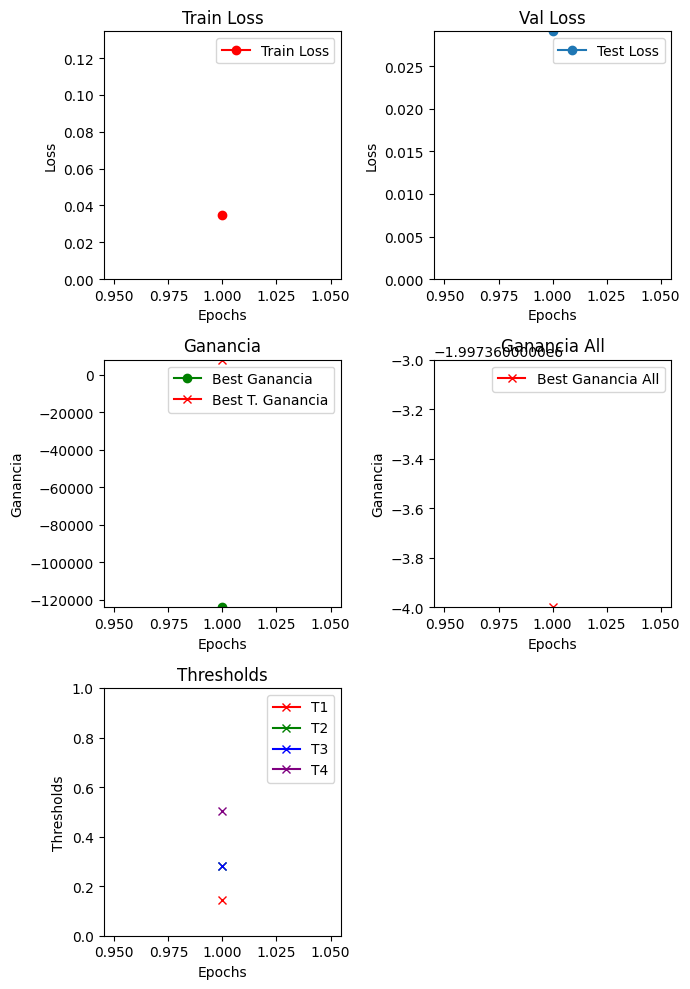

Epoch 2/300:   9%|██████▊                                                                   | 34/368 [00:05<00:52,  6.42it/s, TLoss=0.00367]

In [ ]:
print("By lem0n")
print("-----------------")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using: " + device)

if useTRANSFORMERS:
    model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: Transformers")

elif useTRANSFORMERSHYBRID:
    model = TransformerModelHybrid(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: TransformersHybrid")

elif useACTORCRITIC:
    model = ActorCriticTransformerModel(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: Transformers Actor-Critic")

elif useLSTM:
    model = LSTMModel(input_dim=input_dim, d_model=d_model, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: LSTM")

elif useLSTMAttention:
    model = LSTMModelWithAttention(input_dim=input_dim, d_model=d_model, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: LSTMAttention")

elif useLSTMWeightAtention:
    model = LSTMModelWithAttentionWeight(input_dim=input_dim, d_model=d_model, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: LSTMWeight")

elif useLSTMEncoder:
    model = LSTMModelWithLearnablePositionalEncodings(input_dim=input_dim, d_model=d_model, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
    print("Model: LSTMEncoder")



if not runOPTUNA:
    if setCLASSWEIGHTS:   
        class_weights = torch.tensor(class_weights_vector, dtype=torch.float32).to(device)
    else:
        class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

print(f"Using weights: {class_weights}")
print(f"Using d_model: {d_model}")
print(f"Using dim_feedforward: {dim_feedforward}")
print(f"Using dropout: {dropout}")


print("-----------------")

if not runOPTUNA:


    if useSACMH:


 

        model = ActorCriticOrdinalTransformerModel(
            input_dim=input_dim,  # Replace with your input dimension
            #d_model=512,
            d_model=512,
            num_heads=4,
            #num_heads=8,
            #num_layers=6,
            num_layers=4,
            dim_feedforward=512,
            dropout=0.2,
            num_actor_heads=4,
            #num_actor_heads=10,
            num_classes=5,
            base=10000
        )
        model.to(device)

        class_weights = torch.tensor([50.0, 50.0, 50.0, 50.0, 1, 1], device=device)
        sac_loss = RewardWeightedBCEOrdinalLoss().to(device)




        # Define learning rates
        actor_lr = 5e-6
        critic_lr = 5e-4 #antes -5
        actor_weight_decay = 1e-7  # Example weight decay value for actor
        critic_weight_decay = 1e-7  # Example weight decay value for critic

        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

        





        train_model_sacmh(
            model, 
   #         critic_network,  # Pass the critic network
  #          target_critic_network,  # Pass the target critic network
            train_loader, 
            val_loader, 
            sac_loss,  # Loss function with SAC logic
            optimizer,  # Optimizer for the actor (policy network)
  #          critic_optimizer,  # Optimizer for the critic network
            #alpha_optimizer,  # Optimizer for the learnable alpha parameter
            num_epochs=num_epochs, 
            pad_value=0,  # Ensure the pad value is passed (if needed)
            device=device,
            miss_baja_2_penalty=miss_baja_2_penalty, 
            reward_baja_2=reward_baja_2, 
            penalty_baja_2=penalty_baja_2
        )
    else:
        optimizer = optim_mod.Yogi(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=eps, weight_decay=weight_decay)

        if useACTORCRITIC:
            if withSOFTDISCOUNT:
                criterion = ActorCriticGananciaLoss(class_weights=class_weights, gamma = gamma).to(device)
                print("Using ActorLoss with SOFT DISCOUNTS")
            else:
                criterion = ActorCriticGananciaLossSoft(class_weights=class_weights, gamma = gamma).to(device)
                print("Using ActorLoss with SOFT")     
        else:
            criterion = CustomGananciaLoss(class_weights=class_weights, gamma = gamma).to(device)
            print("Using GananciaLoss")
    
        
        train_model(model, train_loader, val_loader, criterion, optimizer, miss_baja_2_penalty=miss_baja_2_penalty, 
                    reward_baja_2=reward_baja_2, penalty_baja_2= penalty_baja_2, 
                    num_epochs=num_epochs, device=device)


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Hyperparameter suggestions
    learning_rate = trial.suggest_float('lr', 1e-8, 5e-6, log=True)
    print(f"Using learning_rate: {learning_rate}")
    
    num_layers = trial.suggest_int('num_layers', 2, 8)
    print(f"Using num_layers: {num_layers}")
    
    dropout_rate = trial.suggest_float('dropout', 0.05, 0.4)
    print(f"Using dropout_rate: {dropout_rate}")

    num_heads = trial.suggest_categorical('num_heads', [2, 4, 6])
    factor = trial.suggest_int('factor', 150, 300, step=2)
    d_model = num_heads * factor
    print(f"Using num_heads: {num_heads}, d_model: {d_model}")

    dim_factor = trial.suggest_categorical('dim_factor', [1, 2, 3])
    dim_feedforward = d_model * dim_factor
    print(f"Using dim_feedforward: {dim_feedforward}")

    batch_size = trial.suggest_int('batch_size', 200, 400, step=8)
    print(f"Using batch_size: {batch_size}")

    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    print(f"Using weight_decay: {weight_decay}")


    

    # Initialize model with sampled hyperparameters
    model = ActorCriticOrdinalTransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout_rate,
    num_actor_heads=num_heads,
    num_classes=5,
    base=10000
    )
    model = model.to(device)

    # Initialize optimizer with sampled learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize scheduler if needed
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=3, threshold=0.00001)

    # Training parameters
    num_epochs = 12  # Or any number of epochs you prefer
    pad_value = 0
    patience_counter = 0
    max_patience = 3

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False, pin_memory=True)
    sac_loss = RewardWeightedBCEOrdinalLoss().to(device)
    

    # Initialize variables to track the best metrics
    best_ganancia_epoch = float('-inf')
    use_thresholds = None
    early_stop = False

    # Training loop
    for epoch in range(num_epochs):

        if early_stop:
            print("Early stopping triggered.")
            raise optuna.exceptions.TrialPruned()
        
        model.train()
        train_loss = 0.0

        # Training batch loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True, ncols=80)

        for batch in progress_bar:
            X_batch, y_batch = batch

            optimizer.zero_grad()

            # Adjust sequence length if necessary
            X_batch, y_batch = adjust_sequence_length(
                X_batch, y_batch, max_positive_adjust=6, max_negative_adjust=2, pad_value=pad_value, pad_label=5
            )
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).squeeze(-1)

            mask = create_padding_mask(X_batch, pad_value).to(device)
            mask_float = (~mask).float()

            # Skip if all sequences are fully padded
            all_padded = mask.all(dim=1)
            non_empty_indices = (~all_padded).nonzero(as_tuple=True)[0]

            if non_empty_indices.numel() == 0:
                continue

            with autocast():
                action_probs = model(X_batch, src_key_padding_mask=mask)

            with torch.no_grad():
                if use_thresholds != None:
                    predicted_labels = get_class_labels_best(action_probs, thresholds=use_thresholds)
                else:   
                    predicted_labels = get_class_labels(action_probs, threshold=0.5)
                    

            # Compute rewards
            rewards = compute_rewards_ordinal(preds=predicted_labels,labels=y_batch,mask=mask_float,device=device)

            # Compute loss
            total_loss = sac_loss(action_probs=action_probs,target_labels=y_batch,rewards=rewards,mask=mask_float,class_weights=None)

            # Backward pass and optimization
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += total_loss.item()
            progress_bar.set_postfix({"Loss": train_loss / len(train_loader)})

        # Validation loop
        val_loss, best_ganancia, best_argmax_ganancia, best_thresholds, best_ganancia_threshold, _ = validation_loop_sacmh(
            model, val_loader, sac_loss, pad_value, device, None,
            miss_baja_2_penalty, reward_baja_2, penalty_baja_2
        )


        # Update best ganancia
        if best_ganancia > best_ganancia_epoch:
            best_ganancia_epoch = best_ganancia
            use_thresholds = None
            print(f"Changing to thresholds: {use_thresholds}")
        else:
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            patience_counter += 1
            print(f"LR Scheduler Stepping in!: {current_lr}, Patience: {patience_counter}/{max_patience}")

                # Early stopping condition
        if patience_counter > max_patience:
            print(f"Early stopping.")
            early_stop = True
            break
            
            
        # Optional: Implement pruning
        trial.report(best_ganancia, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_ganancia_epoch



In [ ]:
def set_initial_trials(study):
    study.enqueue_trial(Params)

In [ ]:
if runOPTUNA:
    if torch.cuda.is_available():
        torch.cuda.empty_cache() 
    
    study_name = "ganancia_optimization_study_v8"
    storage = f"sqlite:///optuna.db" 
    grace_period_trials = 3
    # Optuna study to maximize ganancia
    pruner = optuna.pruners.MedianPruner(n_startup_trials=grace_period_trials, n_warmup_steps=4)
    study = optuna.create_study(study_name=study_name, direction='maximize', pruner=pruner, storage=storage, load_if_exists=True)  # Maximize ganancia
    
    #pruner = optuna.pruners.HyperbandPruner(min_resource=3, max_resource=num_epochs, reduction_factor=3)
    
    #set_initial_trials(study)
    
    study.optimize(objective, n_trials=n_trials)
    
    # Best trial results
    print(f"Best trial ganancia: {study.best_trial.value}")
    print(f"Best hyperparameters: {study.best_trial.params}")

In [ ]:
def set_initial_trials(study):
    study.enqueue_trial(Params)

In [ ]:
            #threshold_loss_2 = torch.mean(threshold_baja_2_update_signal)
            #model.baja_2_threshold.data += 0.00001 * threshold_loss_2

            #threshold_loss_1 = torch.mean(threshold_baja_1_update_signal)
            #model.baja_1_threshold.data += 0.00001 * threshold_loss_1

            #threshold_loss_c = torch.mean(threshold_continua_update_signal)
            #model.continua_threshold.data += 0.00001 * threshold_loss_c

            #print(f"t_loss: {threshold_loss}")


            # Calculate the threshold update signals based on correct/incorrect classifications
            #threshold_baja_2_update_signal, threshold_baja_1_update_signal, threshold_continua_update_signal = calculate_threshold_update_signal(action_logits, y_batch, model)
            
                        
    




In [ ]:
import copy
import sys
import random
import pickle
import torch
import warnings
import logging
import gc
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_optimizer as optim_mod

from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning

from torch.cuda.amp import autocast, GradScaler
from IPython.display import display, HTML

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

from IPython.display import Javascript, display
from sklearn.utils.multiclass import unique_labels

import optuna
import torch.optim as optim

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

general_logger = logging.getLogger('general_logger')
general_handler = logging.FileHandler('NoForceTransformers_log.txt', mode='w')
general_handler.setFormatter(logging.Formatter('%(message)s'))
general_logger.setLevel(logging.INFO)
general_logger.addHandler(general_handler)


def log(message):
    general_logger.info(message) 
    print(message)     


In [ ]:
#loaded_data_labels = np.load('label_array_filtered_TRAINING3_final.npz', allow_pickle=True)

In [ ]:
label_array = loaded_data_labels['labels']

In [ ]:
label_array = label_array[:, :-2]

In [ ]:
label_array.shape

In [ ]:
# Final corrected conversion function
def convert_labels_to_numeric(label_sequence):
    numerical_labels = np.full(label_sequence.shape, 5, dtype=int)
    numerical_labels[label_sequence == 'OUT'] = 69
    baja2_indices = np.where(label_sequence == 'BAJA+2')[0]
    for baja2_idx in baja2_indices:
        numerical_labels[baja2_idx] = 2
        if (baja2_idx + 1) < len(label_sequence) and label_sequence[baja2_idx + 1] == 'BAJA+1':
            numerical_labels[baja2_idx + 1] = 1
        cont_assignments = [3, 4]
        j = baja2_idx - 1
        for assign in cont_assignments:
            if j >= 0 and label_sequence[j] == 'CONTINUA' and numerical_labels[j] == 5:
                numerical_labels[j] = assign
                j -= 1
            else:
                break
    baja1_indices = np.where(label_sequence == 'BAJA+1')[0]
    assigned_baja1 = baja2_indices + 1
    unassigned_baja1 = baja1_indices[~np.isin(baja1_indices, assigned_baja1)]
    numerical_labels[unassigned_baja1] = 1
    return numerical_labels

In [ ]:
label_array[1367]

In [ ]:
#label_array_regresion = np.array([convert_labels_to_numeric(seq) for seq in label_array])

In [ ]:
label_array_regresion[1367]

In [ ]:
label_array_regresion[12943]

In [ ]:
label_array[1368]

In [ ]:
label_array_regresion[1368]

In [ ]:
#np.savez('label_array_filtered_TRAINING_regresion_final.npz', labels=label_array_regresion)